# First time delay observation between two mid-infrared channels in solar flare footpoints

In [54]:
#Depending on the sections you use, you may need the following libraries
#!pip install sunpy[all]
#!pip install radyn-xtools
#!pip install lightweaver

In [19]:
import os
from os.path import dirname, join as pjoin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
import glob
%matplotlib inline

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import time_support
from astropy.io import fits

from datetime import datetime, timedelta

import sunpy.map
from sunpy import timeseries as ts
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.coordinates import frames

import scipy.io as sio
from scipy.io import readsav
from scipy import signal
from scipy import stats
from scipy import integrate
from scipy.optimize import curve_fit
import scipy.constants as const
from scipy.interpolate import RegularGridInterpolator

import pickle
import math

from typing import List

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
folder= "/content/drive/Othercomputers/UofG_Computer/IR/Delay-observations-mid-infrared-channels-in-solar-flare-footpoints"
#folder=r"G:\Other computers\UofG_Computer\IR\Delay-observations-mid-infrared-channels-in-solar-flare-footpoints"
#folder=r"C:\Users\migue\OneDrive - University of Glasgow\IR\Delay-observations-mid-infrared-channels-in-solar-flare-footpoints"
#folder = "path/to/your/folder"

#DESCRIPTION OF OBSERVATIONS

In [22]:
# Colourblind-friendly palette from colour universal design (CUD)
CB = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']


# https://jfly.uni-koeln.de/color/
named_colors = {"black": "#000000",
    "orange": "#e69f00",
    "skyblue": "#56b4e9",
    "bluish green": "#009e73",
    "yellow": "#f0e442",
    "blue": "#0072b2",
    "vermilion": "#d55e00",
    "reddish purple": "#cc79a7",
}
cud_palette = list(named_colors.values())


def cud(n: int = len(cud_palette), start: int = 0) -> List[str]:
    remainder = cud_palette[:start]
    palette = cud_palette[start:] + remainder
    return palette[:n]

palette = cud()

# Description of Regions of Interest (ROI) on the Sun
We studied the C7.0 class X-ray flare occurred in Active Region 12172 on Sept. 24, 2014 (S11 E22). The Solar Object Locator for this event is SOL2014-09-24T17:50.

Taking as a reference the start of the observations at 17:48:39 UT on 2014-09-24, below are the regions of interest used, specifying their size and the center coordinates in arcseconds. Within each region, the average intensity value was obtained at each time.

---

## 1. Sunspot Penumbra (SP)
- **Size:** 10" x 10"
- **Center:** (-354, -300) arcsec

---

## 2. Flare A (fA)
- **Size:** 10" x 10"
- **Center:** (-365.5, -315.5) arcsec

---

## 3. Flare B (fB)
- **Size:** 10" x 10"
- **Center:** (-368.5, -327) arcsec

---

## 4. Quiet Sun (QS)
- **Size:** 20" x 20"
- **Center:** (-360, -350) arcsec

---

The code below allows retrieving the average intensity variables as a function of time for both channels, the penumbra and the quiet sun from the observations made by MIRI. Additionally, the following cells allow the visualization of intensity variations over time.


In [23]:
df_10 = pd.read_csv(f"{folder}/intensity_data_10um.csv", parse_dates=['time_10'])
df_05 = pd.read_csv(f"{folder}/intensity_data_05um.csv", parse_dates=['time_05'])

sp_I_10 = df_10['sp_I_10'].values
fA_I_10 = df_10['fA_I_10'].values
fB_I_10 = df_10['fB_I_10'].values
qs_I_10 = df_10['qs_I_10'].values
time_10 = df_10['time_10']

sp_I_05 = df_05['sp_I_05'].values
fA_I_05 = df_05['fA_I_05'].values
fB_I_05 = df_05['fB_I_05'].values
qs_I_05 = df_05['qs_I_05'].values
time_05 = df_05['time_05']

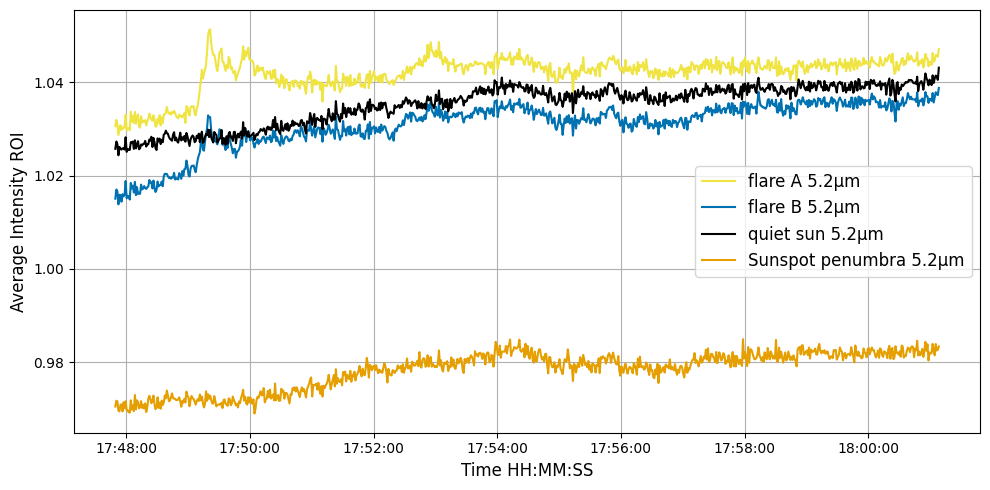

In [24]:
plt.figure(figsize=(10, 5))
plt.xlabel('Time HH:MM:SS',fontsize=12)
plt.ylabel('Average Intensity ROI',fontsize=12)

plt.plot(time_05, fA_I_05, color=palette[4], label='flare A 5.2µm')
plt.plot(time_05, fB_I_05, color=palette[5], label='flare B 5.2µm')
plt.plot(time_05, qs_I_05, color=palette[0], label='quiet sun 5.2µm')
plt.plot(time_05, sp_I_05, color=palette[1], label='Sunspot penumbra 5.2µm')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(fontsize=12)#,loc='lower right')
plt.tight_layout()

plt.show()

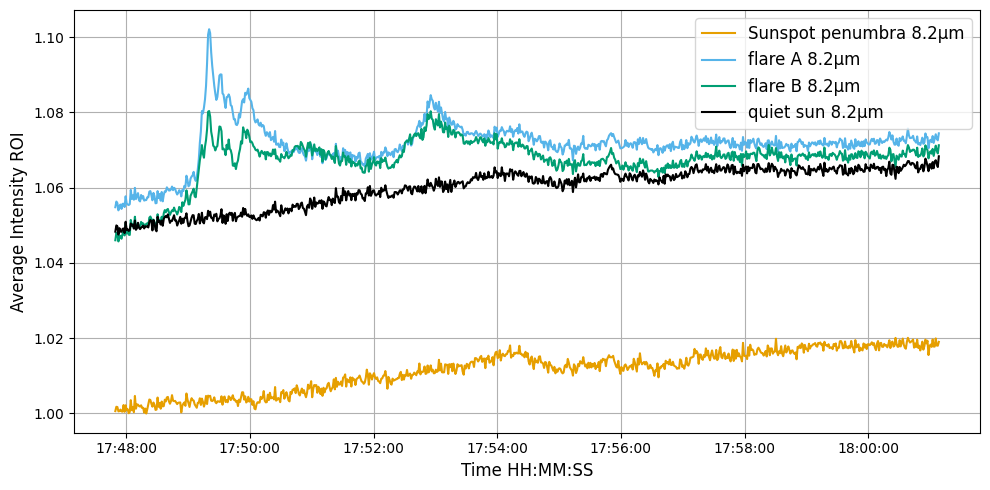

In [25]:
plt.figure(figsize=(10, 5))
plt.xlabel('Time HH:MM:SS',fontsize=12)
plt.ylabel('Average Intensity ROI',fontsize=12)

plt.plot(time_10, sp_I_10, color=palette[1], label='Sunspot penumbra 8.2µm')
plt.plot(time_10, fA_I_10, color=palette[2], label='flare A 8.2µm')
plt.plot(time_10, fB_I_10, color=palette[3], label='flare B 8.2µm')
plt.plot(time_10, qs_I_10, color=palette[0], label='quiet sun 8.2µm')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(fontsize=12)#,loc='lower right')
plt.tight_layout()

plt.show()

Some elements can be observed within the observations, such as a gradual increase in intensity as well as some peaks and intensities that are repeated in all channels; the following code generates a plot that marks these elements within the time series

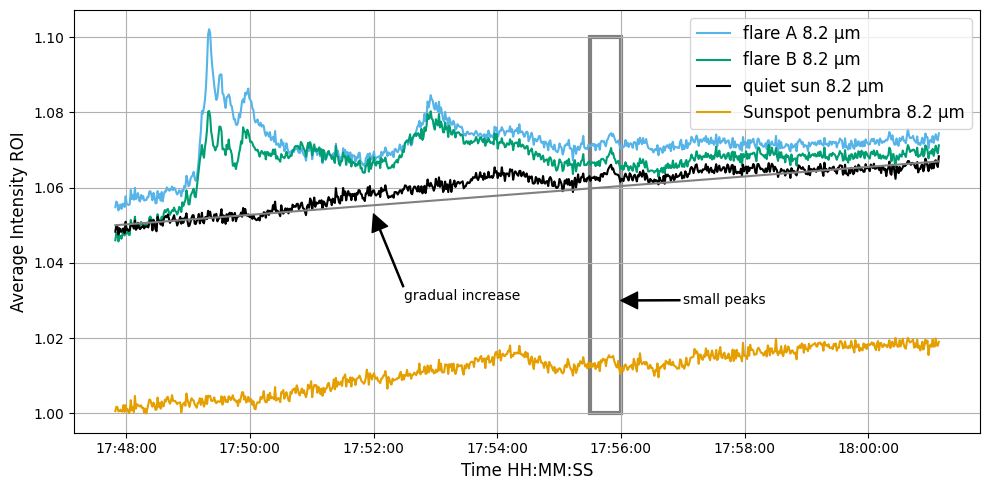

In [26]:
y=np.arange(0, len(time_10), 1)*((1.067-1.05)/len(time_10))+1.05 #Linear estimate of the  gradual increase in intensity.

plt.figure(figsize=(10, 5))
plt.xlabel('Time HH:MM:SS',fontsize=12)
plt.ylabel('Average Intensity ROI',fontsize=12)

plt.plot(time_10, fA_I_10, color=palette[2], label='flare A 8.2 µm')
plt.plot(time_10, fB_I_10, color=palette[3], label='flare B 8.2 µm')
plt.plot(time_10, qs_I_10, color=palette[0], label='quiet sun 8.2 µm')
plt.plot(time_10, sp_I_10, color=palette[1], label='Sunspot penumbra 8.2 µm')

plt.plot(time_10, y, 'grey')
plt.annotate('gradual increase', xy=(datetime(2014,9,24,17,52,00), 1.053), xytext=(datetime(2014,9,24,17,52,30), 1.03), arrowprops=dict(facecolor='k', width=0.8), size=10)
plt.gca().add_patch(Rectangle((datetime(2014,9,24,17,55,30), 1), datetime(2014,9,24,17,52,30)-datetime(2014,9,24,17,52,00),0.1, edgecolor = 'grey', facecolor = 'blue', fill=False, lw=3))
plt.annotate('small peaks', xy=(datetime(2014,9,24,17,56,00), 1.03), xytext=(datetime(2014,9,24,17,57,0), 1.029), arrowprops=dict(facecolor='k', width=0.8), size=10)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(fontsize=12,loc='upper right')
plt.tight_layout()

plt.show()

Finally, the variation of the intensity with respect to the sq intensity is estimated. The following code allows calculating and visualizing the result of this process.

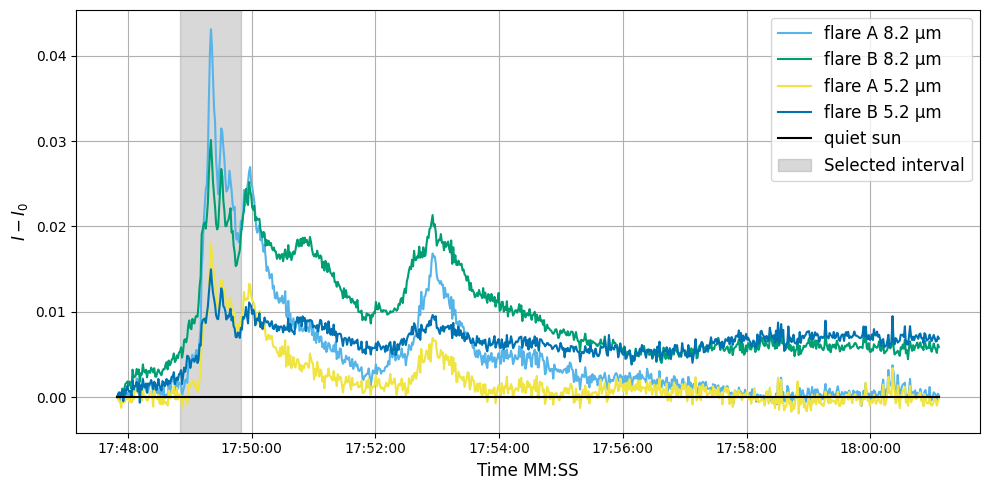

In [27]:
#Plots the intesity variation time series between two given times 8.2 um

t1=datetime(2014,9,24,17,47,0) #the initial date of the time series is 2014, 9, 24, 17, 47, 49, 483000
p_t1 = min(enumerate(time_10), key=lambda x: abs(x[1] - t1))[0] #find the position of the closer index given a date

t2=datetime(2014, 9, 24, 18, 1, 7, 483000) #the final date of the time series is 2014, 9, 24, 18, 1, 7, 483000
p_t2 = min(enumerate(time_10), key=lambda x: abs(x[1] - t2))[0] #find the position of the closer index given a date

# # Shaded area times
t1_s = datetime(2014, 9, 24, 17, 48, 50)
t2_s = datetime(2014, 9, 24, 17, 49, 50)

plt.figure(figsize=(10, 5))
plt.xlabel('Time MM:SS', fontsize=12)
plt.ylabel(r'$I-I_0$', fontsize=12)

plt.plot(time_10[p_t1:p_t2], np.subtract(fA_I_10-fA_I_10[0], qs_I_10-qs_I_10[0])[p_t1:p_t2], color=palette[2], label='flare A 8.2 µm')
plt.plot(time_10[p_t1:p_t2], np.subtract(fB_I_10-fB_I_10[0], qs_I_10-qs_I_10[0])[p_t1:p_t2], color=palette[3], label='flare B 8.2 µm')
plt.plot(time_05[p_t1:p_t2], np.subtract(fA_I_05-fA_I_05[0],qs_I_05-qs_I_05[0])[p_t1:p_t2], color=palette[4], label='flare A 5.2 µm')
plt.plot(time_05[p_t1:p_t2], np.subtract(fB_I_05-fB_I_05[0],qs_I_05-qs_I_05[0])[p_t1:p_t2], color=palette[5], label='flare B 5.2 µm')
plt.plot(time_10[p_t1:p_t2], np.subtract(qs_I_10-qs_I_10[0], qs_I_10-qs_I_10[0])[p_t1:p_t2], color=palette[0], label='quiet sun')

# Shaded area
plt.axvspan(t1_s, t2_s, color='gray', alpha=0.3, label='Selected interval')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
plt.xticks(rotation=0)

plt.grid(True)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()

plt.show()

## GOES data

The cells in the following segment allow you to visualize the GOES X-ray fluxes recorded for the C7.0 flare in the 1.0 - 8.0 Å  and 0.5 - 4.0 Å channels.

In [28]:
file_goes15 = f"{folder}/goes_data.nc"
goes_15 = ts.TimeSeries(file_goes15)

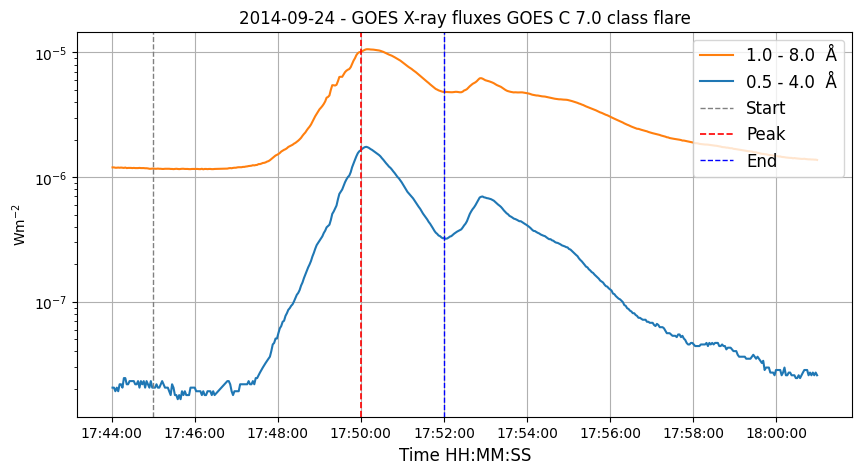

In [29]:
from datetime import datetime

df = goes_15.to_dataframe()
goes_15 = ts.TimeSeries(df, goes_15.meta, goes_15.units)

goes_flare = goes_15.truncate("2014-09-24 17:44", "2014-09-24 18:01")
time_support()

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("2014-09-24 - GOES X-ray fluxes GOES C 7.0 class flare")

ax.plot(goes_flare.time.datetime, goes_flare.quantity("xrsb"), label = "1.0 - 8.0  Å", color="C1")
ax.plot(goes_flare.time.datetime, goes_flare.quantity("xrsa"), label ="0.5 - 4.0  Å", color="C0")

ax.set_ylabel("Wm$^{-2}$")

# Líneas verticales
# Convertir cada Time a datetime compatible con matplotlib
from astropy.time import Time

start = Time('2014-09-24T17:45:00')
peak  = Time('2014-09-24T17:50:00')
end   = Time('2014-09-24T17:52:00')

ax.axvline(start.datetime, color="grey", linestyle="--", linewidth=1, label="Start")
ax.axvline(peak.datetime,  color="red",  linestyle="--", linewidth=1.2, label="Peak")
ax.axvline(end.datetime,   color="blue", linestyle="--", linewidth=1, label="End")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
ax.grid(True)

ax.legend(fontsize=12, loc='upper right')
ax.set_xlabel('Time HH:MM:SS', fontsize=12)
ax.set_yscale('log')

plt.show()

In this cell, the soft X-ray flow is diverted to have a proxy for the hard X-rays.

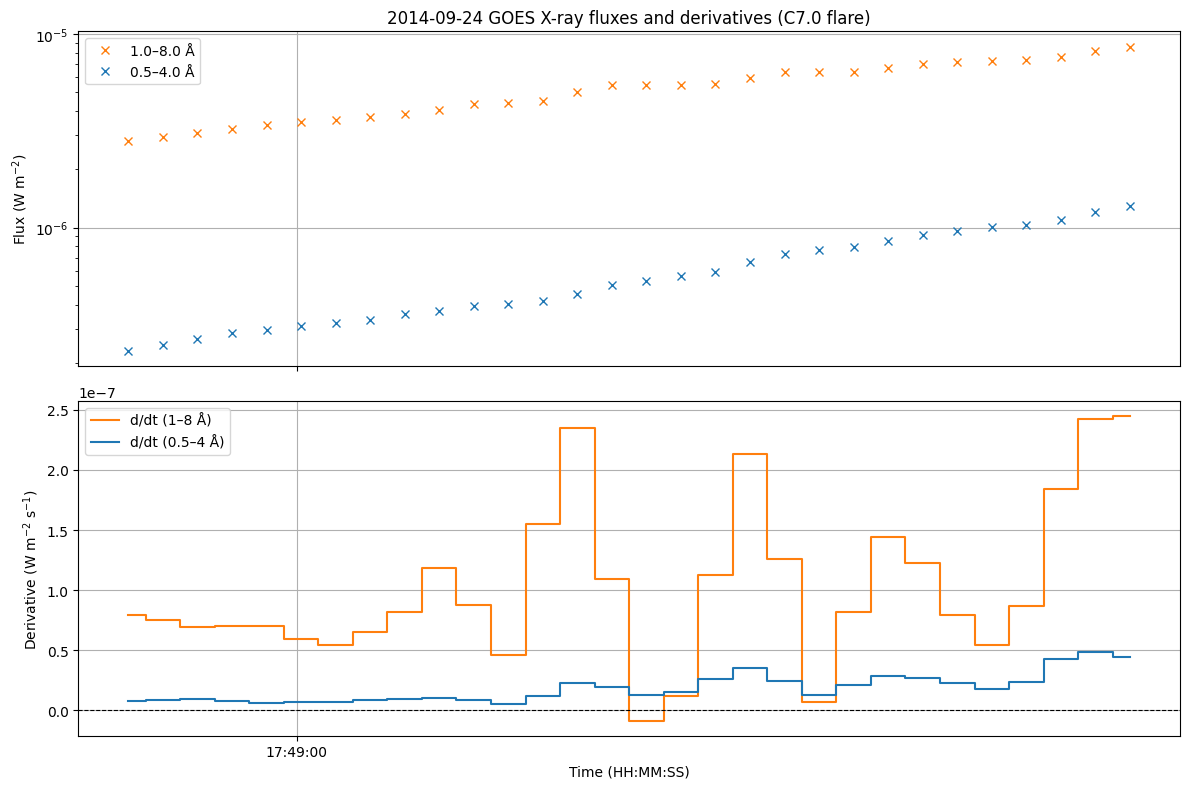

In [30]:
# --- DataFrame ---
df = goes_15.to_dataframe()
goes_15 = ts.TimeSeries(df, goes_15.meta, goes_15.units)

goes_flare = goes_15.truncate("2014-09-24 17:48:50", "2014-09-24 17:49:50")

# === Original Data ===
times = goes_flare.time.datetime
flux_a = goes_flare.quantity("xrsa").value   # 1-8 Å
flux_b = goes_flare.quantity("xrsb").value   # 0.5-4 Å

# === Derivatives ===
# convert datetime to seconds relative to t0
t_seconds = (times - times[0]).astype("timedelta64[s]").astype(float)

dflux_a = np.gradient(flux_a, t_seconds)  # d(flux)/dt
dflux_b = np.gradient(flux_b, t_seconds)
# Gradient in numpy uses: second-order accurate central difference

# === Plot ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Panel 1: Flux
ax1.set_title("2014-09-24 GOES X-ray fluxes and derivatives (C7.0 flare)")
ax1.plot(times, flux_b, 'x',label="1.0–8.0 Å", color="C1")
ax1.plot(times, flux_a,'x', label="0.5–4.0 Å", color="C0")
ax1.set_ylabel("Flux (W m$^{-2}$)")
ax1.set_yscale("log")
ax1.legend()
ax1.grid(True)

# Panel 2: Derivatives
ax2.step(times, dflux_b, where='mid', color="C1", label="d/dt (1–8 Å)")
ax2.step(times, dflux_a, where='mid', color="C0", label="d/dt (0.5–4 Å)")

ax2.axhline(0, color="k", linestyle="--", linewidth=0.8)
ax2.set_ylabel("Derivative (W m$^{-2}$ s$^{-1}$)")
ax2.legend()
ax2.grid(True)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax2.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
ax2.set_xlabel("Time (HH:MM:SS)")

plt.tight_layout()
plt.show()

# ANALYSIS AND RESULTS

## Lag estimation using the Cross-correlation (CCF) and Local CCF for a known signal

The standard definition of the CCF of two time series $x_i$ and $y_i$ sampled at discrete times $t_i(i=1, \ldots, N)$ with equal sampling ( $\Delta t=t_{i+1}-t_i$ ) is

$$
\operatorname{CCF}\left(\tau_k\right) \equiv \frac{\frac{1}{N} \sum_{i=1}^{N-k}\left(x_i-\bar{x}\right)\left(y_{i+k}-\bar{y}\right)}{\left[\frac{1}{N} \sum_{i=1}^N\left(x_i-\bar{x}\right)^2\right]^{1 / 2}\left[\frac{1}{N} \sum_{i=1}^N\left(y_i-\bar{y}\right)^2\right]^{1 / 2}},
$$

where the lag $\tau_k$ is the size of the time shift: $\tau_k=k \Delta t$, $k=0, \ldots, N-1$ and $\bar{x}, \bar{y}$ are the means of $x_i$ and $y_i$.

In the other hand, the suggested Local Cross Correlation function is defined as:

$$
C C F_L\left(\tau_k\right) \equiv A
$$

where

$$
A=\frac{\frac{1}{(N-k)} \sum_{i=1}^{N-k}\left(x_i-\bar{x}_*\right)\left(y_{i+k}-\overline{y_*}\right)}{\left[\frac{1}{(N-k)} \sum_{i=1}^{N-k}\left(x_i-\bar{x}_*\right)^2\right]^{1 / 2}\left[\frac{1}{(N-k)} \sum_{i=k+1}^N\left(y_i-\bar{y}_*\right)^2\right]^{1 / 2}}
$$

where $\tau_k=k \Delta t$ and

$$
\overline{x_*}=\frac{1}{N-k} \sum_{i=1}^{N-k} x_i, \quad \overline{y_*}=\frac{1}{N-k} \sum_{i=k+1}^N y_i
$$

To assess the performance of each definition, the local and standar CCF was applied to a well-known noise-free signal lagged by 0.75 s.

The code here allows this simulated intensity to be calculated, and then both techniques were applied to estimate the lag.


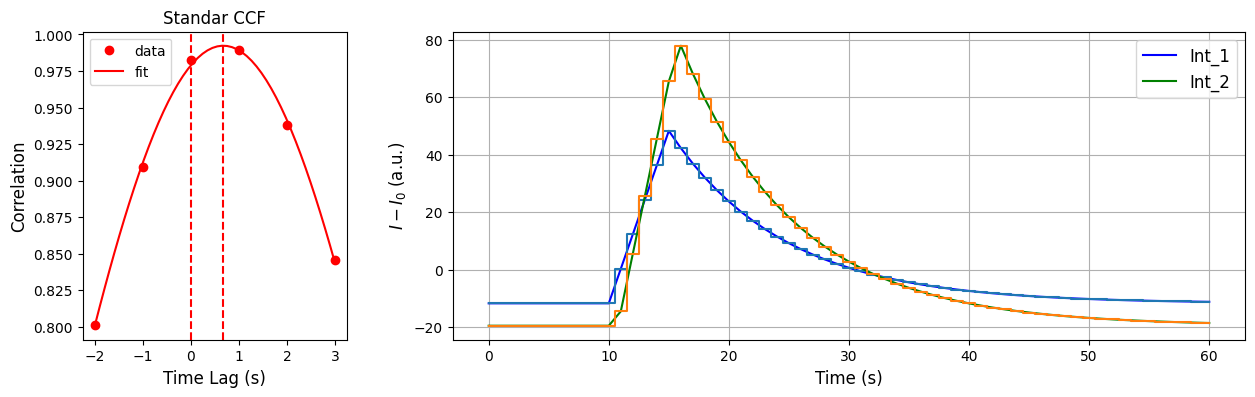

Estimated time lag (max value of the fitting function): 0.67s
Standard deviation error 0.02s


In [31]:
#Using a flare function with a known lag of 0.75s:
#Flare light curve modeled as linear growth followed by a potencial decrese
def flare(x,t0,h,k,a):
    r = []
    for i in range(len(x)):
        if (x[i]<h):
            r_i=(k/(h-t0))*x[i]-k*t0/(h-t0)
            if (r_i>0):
                r.append(r_i)
            else:
                r.append(0)
        else:
            r_i=k*a**((x[i]-h))
            r.append(r_i)
    return r

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

#the analysed signals have arround 1min lenght
lt=61#lenght of time series
st=60/(lt-1) #step size in time
na=0 #Noise Amplitude
ns_1=2#Number of seconds to consider un the fit
ns_2=3
ttl=0.75 #theoretical time lag

noise_1 = np.random.uniform(low=-na, high=na, size=(lt))
noise_2 = np.random.uniform(low=-na, high=na, size=(lt))
t=np.linspace(0,60,lt)
Int_1=(flare(t,10,15,100,0.9)+noise_1)*0.6
Int_2=flare(t, 10+ttl,15+ttl,100,0.9)+noise_2

#Correlation function
mean_Int_1=np.mean(Int_1)
mean_Int_2=np.mean(Int_2)
Norm=np.std(Int_1)*np.std(Int_2)*len(Int_1)

correlation = signal.correlate(Int_2-mean_Int_2,Int_1-mean_Int_1,  mode="full")/Norm
lags = signal.correlation_lags(Int_1.size, Int_2.size, mode="full")
lag = lags[np.argmax(correlation)]

x=lags[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]*st
y=correlation[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]

#Fitting
popt,pcov = curve_fit(gaus,x,y)

#Plot
fig = plt.figure(figsize=(15,4))
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 3], height_ratios=[1])

ax1 = fig.add_subplot(spec[1])

ax1.set_xlabel('Time (s)',fontsize=12)
ax1.set_ylabel(r'$I-I_0$ (a.u.)',fontsize=12)
ax1.plot(t, Int_1-mean_Int_1, 'b', label='Int_1')
ax1.step(t, Int_1-mean_Int_1, where='mid')
ax1.plot(t, Int_2-mean_Int_2, 'g', label='Int_2')
ax1.step(t, Int_2-mean_Int_2, where='mid')
ax1.grid(True)
ax1.legend(fontsize=12,loc='upper right')

ax2 = fig.add_subplot(spec[0])
ax2.plot(x,y,'ro',label='data')
x_ls=(np.linspace(-ns_1, ns_2, num=50))
ax2.plot(x_ls,gaus(x_ls,*popt),'r',label='fit')
ax2.axvline(0, color='r', linestyle='--')
ax2.axvline(popt[1], color='r', linestyle='--')
ax2.legend()
ax2.set_title('Standar CCF')
ax2.set_xlabel('Time Lag (s)',fontsize=12)
ax2.set_ylabel('Correlation',fontsize=12)

plt.show()
print(f"Estimated time lag (max value of the fitting function): {round(popt[1],2)}s")
perr = np.sqrt(np.diag(pcov))
print(f"Standard deviation error {round(perr[1],2)}s")


In [32]:
def localCCF(x0,y0,k):
    N= len(x0)

    if k>=0:
        x=x0
        y=y0
    else:
        y=x0
        x=y0

    k=abs(k)
    x_ave=(1/(N-k))*np.sum(x[0:N-k])
    y_ave=(1/(N-k))*np.sum(y[(k+1)-1:N])
    c1=np.sum((1/(N-k))*np.square(x[0:N-k]-x_ave))
    c2=np.sum((1/(N-k))*np.square(y[(k+1)-1:N]-y_ave))
    c=0
    for i in range(N-k):
        c=c+((1/(N-k))*(x[i]-x_ave)*(y[i+k]-y_ave))
    ccf= c/(np.sqrt(c1)*np.sqrt(c2))
    return ccf

def TlocalCCF(x0,y0):
    tccf=[]
    k=len(x0)
    for i in range((-k+3),(k-2)):
        tccf.append(localCCF(x0,y0,i))
    return(tccf)

#Note that the way the correlation function is defined here does not match the way the scipy.correlate function is defined with respect to the order of the variables.
#To obtain comparable results, the function TlocalCCF(x,y) should be compared with signal.correlate(y,x)

/tmp/ipython-input-1403037697.py:19: RuntimeWarning: invalid value encountered in scalar divide
  ccf= c/(np.sqrt(c1)*np.sqrt(c2))


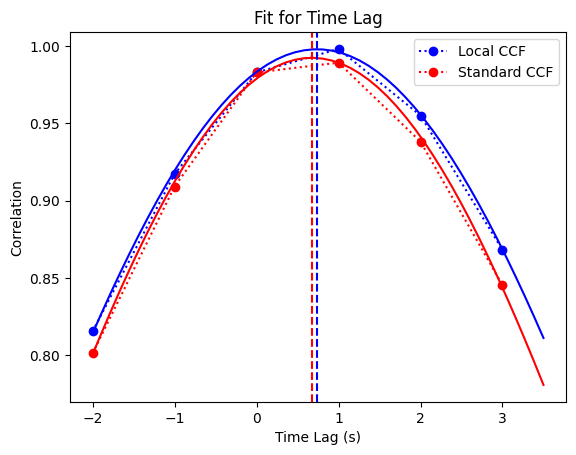

Estimated time lag (max value of the fitting function) using local CCF: 0.74s
Standard deviation error 0.01s
Estimated time lag (max value of the fitting function) using standard CCF: 0.67s
Standard deviation error 0.017s


In [33]:
#The analysed signals have arround 1min lenght
lt=61#lenght of time series
st=60/(lt-1) #step size in time
na=0 #Noise Amplitude
ns_1=5#Number of seconds to consider un the fit
ns_2=6
ttl=0.75 #theoretical time lag

noise_1 = np.random.uniform(low=-na, high=na, size=(lt))
noise_2 = np.random.uniform(low=-na, high=na, size=(lt))
t=np.linspace(0,60,lt)
Int_1=(flare(t,10,15,100,0.9)+noise_1)*0.6
Int_2=flare(t, 10+ttl,15+ttl,100,0.9)+noise_2

#Correlation function
mean_Int_1=np.mean(Int_1)
mean_Int_2=np.mean(Int_2)
Norm=np.std(Int_1)*np.std(Int_2)*len(Int_1)

#We try two different cross correlation functions, local CCF and standard CCF
#Local CCF
correlation_1 = TlocalCCF(Int_1,Int_2)
k=len(Int_1)
lags_1 = np.arange(-k+3, k-2, 1) #Len of 95, the lag 0 is at 47

#Standard CCF
correlation_2 = signal.correlate(Int_2-mean_Int_2, Int_1-mean_Int_1, mode="full")/Norm
lags_2 = signal.correlation_lags(Int_2.size, Int_1.size, mode="full")

x1=lags_1[56:62]# 58 is the lag equal to zero
y1=correlation_1[56:62] #

x2=lags_2[58:64]# 60is the lag equal to zero
y2=correlation_2[58:64] #


n = len(x1)                          #the number of data
mean = sum(x1*y1)/n
sigma = sum(y1*(x1-mean)**2)/n

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

popt1,pcov1 = curve_fit(gaus,x1,y1,p0=[1,mean,sigma])
popt2,pcov2 = curve_fit(gaus,x2,y2,p0=[1,mean,sigma])

plt.plot(x1,y1,'bo:',label='Local CCF')
plt.plot(x2,y2,'ro:',label='Standard CCF')
x_ls=np.linspace(-2, 3.5, num=50)
plt.plot(x_ls,gaus(x_ls,*popt1),'b')
plt.plot(x_ls,gaus(x_ls,*popt2),'r')
#plt.axvline(0, color='g', linestyle='--')
plt.axvline(popt1[1], color='b', linestyle='--')
plt.axvline(popt2[1], color='r', linestyle='--')
plt.legend(loc= 'upper right')
plt.title('Fit for Time Lag')
plt.xlabel('Time Lag (s)')
plt.ylabel('Correlation')
plt.show()

print(f"Estimated time lag (max value of the fitting function) using local CCF: {round(popt1[1], 2) }s")
perr = np.sqrt(np.diag(pcov1))
print(f"Standard deviation error {round(perr[1],3)}s")

print(f"Estimated time lag (max value of the fitting function) using standard CCF: {round(popt2[1], 2)}s")
perr = np.sqrt(np.diag(pcov2))
print(f"Standard deviation error {round(perr[1],3)}s")

Second option:
Considering a signal with 10% noise and a lag of 0.3s

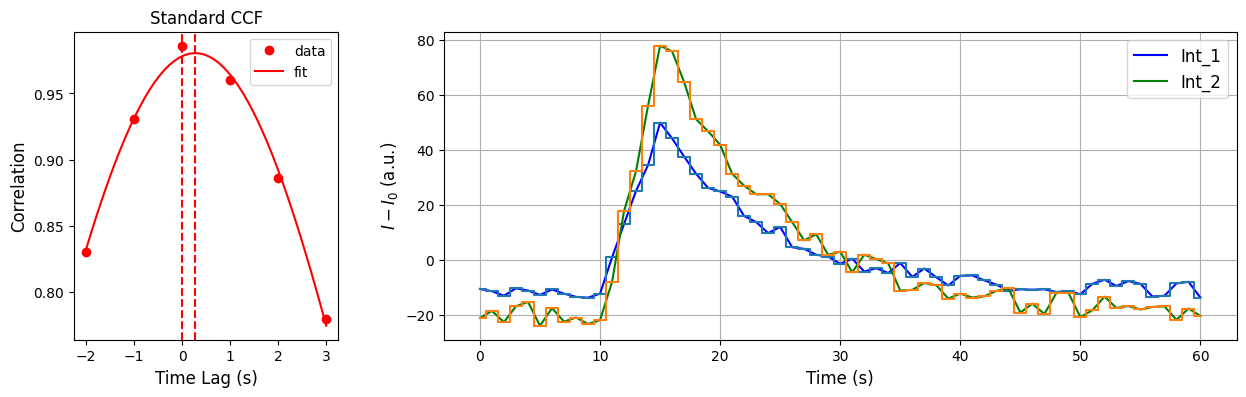

Estimated time lag (max value of the fitting function): 0.27s
Standard deviation error 0.03s


In [34]:

#the analysed signals have arround 1min lenght
lt=61#lenght of time series
st=60/(lt-1) #step size in time
na=5 #Noise Amplitude
ns_1=2#Number of seconds to consider un the fit
ns_2=3
ttl=0.3 #theoretical time lag

noise_1 = np.random.uniform(low=-na, high=na, size=(lt))
noise_2 = np.random.uniform(low=-na, high=na, size=(lt))
t=np.linspace(0,60,lt)
Int_1=(flare(t,10,15,100,0.9)+noise_1)*0.6
Int_2=flare(t, 10+ttl,15+ttl,100,0.9)+noise_2

#Correlation function
mean_Int_1=np.mean(Int_1)
mean_Int_2=np.mean(Int_2)
Norm=np.std(Int_1)*np.std(Int_2)*len(Int_1)

correlation = signal.correlate(Int_2-mean_Int_2,Int_1-mean_Int_1,  mode="full")/Norm
lags = signal.correlation_lags(Int_1.size, Int_2.size, mode="full")
lag = lags[np.argmax(correlation)]

x=lags[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]*st
y=correlation[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]

#Fitting
popt,pcov = curve_fit(gaus,x,y)

#Plot
fig = plt.figure(figsize=(15,4))
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 3], height_ratios=[1])

ax1 = fig.add_subplot(spec[1])

ax1.set_xlabel('Time (s)',fontsize=12)
ax1.set_ylabel(r'$I-I_0$ (a.u.)',fontsize=12)
ax1.plot(t, Int_1-mean_Int_1, 'b', label='Int_1')
ax1.step(t, Int_1-mean_Int_1, where='mid')
ax1.plot(t, Int_2-mean_Int_2, 'g', label='Int_2')
ax1.step(t, Int_2-mean_Int_2, where='mid')
ax1.grid(True)
ax1.legend(fontsize=12,loc='upper right')

ax2 = fig.add_subplot(spec[0])
ax2.plot(x,y,'ro',label='data')
x_ls=(np.linspace(-ns_1, ns_2, num=50))
ax2.plot(x_ls,gaus(x_ls,*popt),'r',label='fit')
ax2.axvline(0, color='r', linestyle='--')
ax2.axvline(popt[1], color='r', linestyle='--')
ax2.legend()
ax2.set_title('Standard CCF')
ax2.set_xlabel('Time Lag (s)',fontsize=12)
ax2.set_ylabel('Correlation',fontsize=12)

plt.show()
print(f"Estimated time lag (max value of the fitting function): {round(popt[1],2)}s")
perr = np.sqrt(np.diag(pcov))
print(f"Standard deviation error {round(perr[1],2)}s")


## Lag estimation using the Cross-correlation (CCF) and Local CCF for a flare signal in mid infrared

The use of the local correlation function has been proposed as an alternative approach to mitigate lag underestimation, as this definition reduces the bias towards zero  (see Welsh 1999 reference in the paper).

Taking these aspects into account, the lag value estimated in the Simoes et al 2024 paper is slightly underestimated; to correct this aspect, it is possible to use the local cross-correlation function instead.

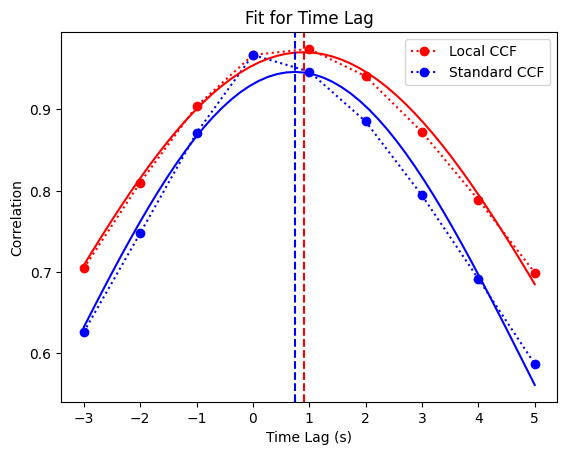

Estimated time lag (max value of the fitting function) using local CCF: 0.9s
Standard deviation error 0.044s
Estimated time lag (max value of the fitting function) using standard CCF: 0.74s
Standard deviation error 0.075s


In [35]:
t1=datetime(2014,9,24,17,49,0) #the initial date of the time series is 2014, 9, 24, 17, 47, 49, 483000
p_t1 = min(enumerate(time_10), key=lambda x: abs(x[1] - t1))[0] #find the position of the closer index given a date

t2=datetime(2014, 9, 24, 17, 49, 50, 0) #the final date of the time series is 2014, 9, 24, 18, 1, 7, 483000
p_t2 = min(enumerate(time_10), key=lambda x: abs(x[1] - t2))[0] #find the position of the closer index given a date

#Intended to subtract a vector, for example if necessary subtract the qs value to obtain the relative variations.
subtract= qs_I_10
fA_Isub=np.subtract(fA_I_10,subtract)[p_t1:p_t2]
fB_Isub=np.subtract(fB_I_10,subtract)[p_t1:p_t2]

mean_fA_Isub=np.average(fA_Isub)
mean_fB_Isub=np.average(fB_Isub)

x=fA_Isub-mean_fA_Isub
y=fB_Isub-mean_fB_Isub
Norm=np.std(x)*np.std(y)*len(x)

#We try two different cross correlation functions, local CCF and standard CCF
#Local CCF
correlation_1 = TlocalCCF(y,x)
k=len(x)
lags_1 = np.arange(-k+3, k-2, 1) #Len of 95, the lag 0 is at 47

#Standard CCF (used by Simoes et al 2024)
correlation_2 = signal.correlate(x, y, mode="full")/Norm
lags_2 = signal.correlation_lags(y.size, x.size, mode="full")


x1=lags_1[44:53]# 47 is the lag equal to zero
y1=correlation_1[44:53] #

x2=lags_2[46:55]# 49 is the lag equal to zero
y2=correlation_2[46:55] #


n = len(x)   #the number of data points
mean = sum(x1*y1)/n
sigma = sum(y1*(x1-mean)**2)/n

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

popt1,pcov1 = curve_fit(gaus,x1,y1,p0=[1,mean,sigma])
popt2,pcov2 = curve_fit(gaus,x2,y2,p0=[1,mean,sigma])

plt.plot(x1,y1,'ro:',label='Local CCF')
plt.plot(x2,y2,'bo:',label='Standard CCF')
x_ls=np.linspace(-3, 5, num=50)
plt.plot(x_ls,gaus(x_ls,*popt1),'r')
plt.plot(x_ls,gaus(x_ls,*popt2),'b')
#plt.axvline(0, color='g', linestyle='--')
plt.axvline(popt1[1], color='r', linestyle='--')
plt.axvline(popt2[1], color='b', linestyle='--')
plt.legend(loc= 'upper right')
plt.title('Fit for Time Lag')
plt.xlabel('Time Lag (s)')
plt.ylabel('Correlation')
plt.show()

print(f"Estimated time lag (max value of the fitting function) using local CCF: {round(popt1[1], 2) }s")
perr = np.sqrt(np.diag(pcov1))
print(f"Standard deviation error {round(perr[1],3)}s")

print(f"Estimated time lag (max value of the fitting function) using standard CCF: {round(popt2[1], 2)}s")
perr = np.sqrt(np.diag(pcov2))
print(f"Standard deviation error {round(perr[1],3)}s")

## Time delay between 5.2 and $8.2 \mu \mathrm{~m}$ channels

Once the local cross-correlation technique is established, the following code allows calculating the lag between each of the observed channels using MIRI

/tmp/ipython-input-1227265062.py:276: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


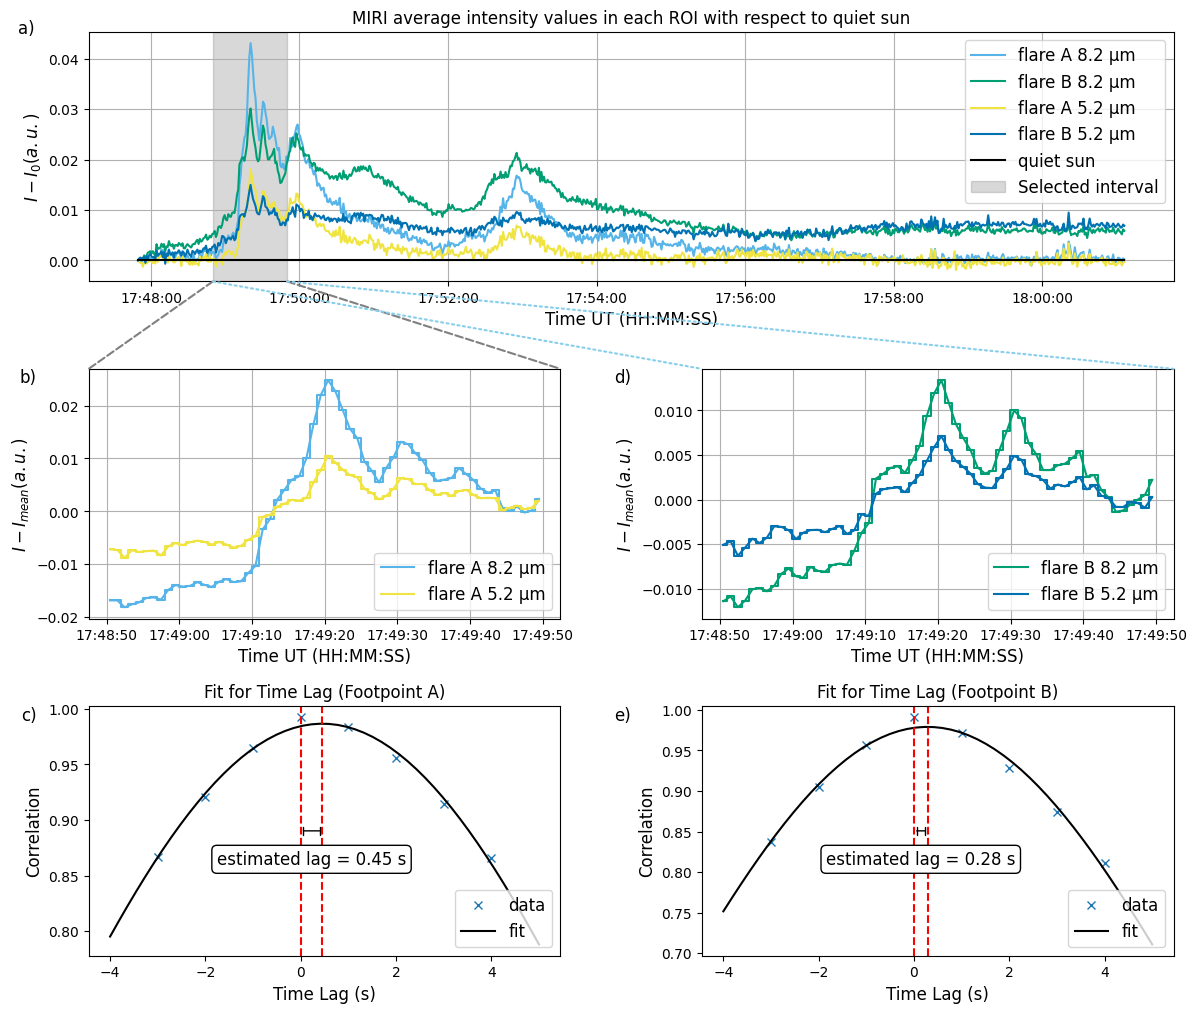

In [36]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.patches import ConnectionPatch


# --- Create figure and 2x3 grid ---
fig = plt.figure(figsize=(14, 12))
spec = gridspec.GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.3)

# ========== ROW 1 ==========
# Intensity curves with shading
ax1 = fig.add_subplot(spec[0, :])  # spans entire row (colspan=2)

t1=datetime(2014,9,24,17,47,0)
p_t1 = min(enumerate(time_10), key=lambda x: abs(x[1] - t1))[0]

t2=datetime(2014, 9, 24, 18, 1, 7, 483000)
p_t2 = min(enumerate(time_10), key=lambda x: abs(x[1] - t2))[0]

t1_s = datetime(2014, 9, 24, 17, 48, 50)
t2_s = datetime(2014, 9, 24, 17, 49, 50)

ax1.set_title('MIRI average intensity values in each ROI with respect to quiet sun')
ax1.set_xlabel('Time UT (HH:MM:SS)', fontsize=12)
ax1.set_ylabel(r'$I-I_0  (a.u.)$', fontsize=12)

ax1.plot(time_10[p_t1:p_t2],
         np.subtract(fA_I_10-fA_I_10[0], qs_I_10-qs_I_10[0])[p_t1:p_t2],
         color=palette[2], label='flare A 8.2 µm')
ax1.plot(time_10[p_t1:p_t2],
         np.subtract(fB_I_10-fB_I_10[0], qs_I_10-qs_I_10[0])[p_t1:p_t2],
         color=palette[3], label='flare B 8.2 µm')

ax1.plot(time_05[p_t1:p_t2],
         np.subtract(fA_I_05-fA_I_05[0], qs_I_05-qs_I_05[0])[p_t1:p_t2],
         color=palette[4], label='flare A 5.2 µm')
ax1.plot(time_05[p_t1:p_t2],
         np.subtract(fB_I_05-fB_I_05[0], qs_I_05-qs_I_05[0])[p_t1:p_t2],
         color=palette[5], label='flare B 5.2 µm')

ax1.plot(time_05[p_t1:p_t2],
         np.subtract(qs_I_05-qs_I_05[0], qs_I_05-qs_I_05[0])[p_t1:p_t2],
         color=palette[0], label='quiet sun')

ax1.axvspan(t1_s, t2_s, color='gray', alpha=0.3, label='Selected interval')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
ax1.tick_params(axis='x', rotation=0)
ax1.grid(True)
ax1.legend(fontsize=12, loc='upper right')

# ========== LEFT COLUMN (FOOTPOINT A) ==========
t1=datetime(2014,9,24,17,48,50) #the initial date of the time series is 2014, 9, 24, 17, 47, 49, 483000
p_t1 = min(enumerate(time_10), key=lambda x: abs(x[1] - t1))[0] #find the position of the closer index given a date

t2=datetime(2014, 9, 24, 17, 49, 50, 0) #the final date of the time series is 2014, 9, 24, 18, 1, 7, 483000
p_t2 = min(enumerate(time_10), key=lambda x: abs(x[1] - t2))[0] #find the position of the closer index given a date

Int_1=np.subtract(fA_I_10-fA_I_10[0],qs_I_10-qs_I_10[0])[p_t1:p_t2]
Int_2=np.subtract(fA_I_05-fA_I_05[0],qs_I_05-qs_I_05[0])[p_t1:p_t2]
t=time_10[p_t1:p_t2]

mean_Int_1=np.average(Int_1)
mean_Int_2=np.average(Int_2)

#Correlation function
Norm=np.std(Int_1)*np.std(Int_2)*len(Int_1)
ns_1=4#Number of seconds to consider in the fit
ns_2=5
st=1 #time step size in seconds

correlation = TlocalCCF(Int_1, Int_2)

k=len(Int_1)
lags = np.arange(-k+3, k-2, 1)

x=lags[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]*st
y=correlation[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]

n = len(x)                          #the number of data
mean = sum(x*y)/n
sigma = sum(y*(x-mean)**2)/n
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

#Fitting
popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

# ====================
# Left column: Intensity curve Flare A
ax4 = fig.add_subplot(spec[1, 0])
ax4.set_xlabel('Time UT (HH:MM:SS)', fontsize=12)
ax4.set_ylabel(r'$I-I_{mean}  (a.u.)$', fontsize=12)
ax4.plot(t, Int_1-mean_Int_1, color=palette[2], label='flare A 8.2 µm')
ax4.step(t, Int_1-mean_Int_1, color=palette[2], where='mid')
ax4.plot(t, Int_2-mean_Int_2, color=palette[4], label='flare A 5.2 µm')
ax4.step(t, Int_2-mean_Int_2, color=palette[4], where='mid')
ax4.grid(True)
ax4.legend(fontsize=12, loc='lower right')

# Left column: Fit point A
ax2 = fig.add_subplot(spec[2, 0])
ax2.plot(x, y, 'x', label='data')
x_ls = np.linspace(-ns_1, ns_2, num=50)
ax2.plot(x_ls, gaus(x_ls, *popt), color=palette[0], label='fit')
ax2.axvline(0, color='r', linestyle='--')
ax2.axvline(popt[1], color='r', linestyle='--')

# Create a bracket (with FancyBracket or FancyArrowPatch bracket style)
bracket = mpatches.FancyArrowPatch(
    (0, 0.5), (popt[1], 0.5),  # initial and final coordinates in X
    transform=ax2.get_xaxis_transform(),  # relative to X axis
    arrowstyle='|-|,widthA=0.2,widthB=0.2',  # bracket style
    mutation_scale=15,  # bracket size
    color="black"
)
ax2.add_patch(bracket)

# Add centered text between the two lines
x_middle = (0 + popt[1]) / 2
ax2.text(
    x_middle, 0.35, f"estimated lag = {popt[1]:.2f} s",
    ha="center", va="bottom",
    transform=ax2.get_xaxis_transform(), fontsize=12,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
)
ax2.set_title('Fit for Time Lag (Footpoint A)')
ax2.set_xlabel('Time Lag (s)', fontsize=12)
ax2.set_ylabel('Correlation', fontsize=12)
ax2.legend(fontsize=12, loc='lower right')

# ========== RIGHT COLUMN (FOOTPOINT B) ==========
Int_1=np.subtract(fB_I_10-fB_I_10[0],qs_I_10-qs_I_10[0])[p_t1:p_t2]
Int_2=np.subtract(fB_I_05-fB_I_05[0],qs_I_05-qs_I_05[0])[p_t1:p_t2]
t=time_10[p_t1:p_t2]

mean_Int_1=np.average(Int_1)
mean_Int_2=np.average(Int_2)

#Correlation function
Norm=np.std(Int_1)*np.std(Int_2)*len(Int_1)
ns_1=4 #Number of seconds to consider in the fit
ns_2=5
st=1 #time step size in seconds

correlation = TlocalCCF(Int_1, Int_2)

k=len(Int_1)
lags = np.arange(-k+3, k-2, 1)

x=lags[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]*st
y=correlation[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]

n = len(x)                          #the number of data
mean = sum(x*y)/n
sigma = sum(y*(x-mean)**2)/n

#Fitting
popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

# ====================
# Right column: Intensity curve Flare B
ax3 = fig.add_subplot(spec[1, 1])
ax3.set_xlabel('Time UT (HH:MM:SS)', fontsize=12)
ax3.set_ylabel(r'$I-I_{mean}  (a.u.)$', fontsize=12)
ax3.plot(t, Int_1-mean_Int_1, color=palette[3], label='flare B 8.2 µm')
ax3.step(t, Int_1-mean_Int_1, color=palette[3], where='mid')
ax3.plot(t, Int_2-mean_Int_2, color=palette[5], label='flare B 5.2 µm')
ax3.step(t, Int_2-mean_Int_2, color=palette[5], where='mid')
ax3.grid(True)
ax3.legend(fontsize=12, loc='lower right')

# Right column: Fit point B
ax5 = fig.add_subplot(spec[2, 1])
ax5.plot(x, y, 'x', label='data')
x_ls = np.linspace(-ns_1, ns_2, num=50)
ax5.plot(x_ls, gaus(x_ls, *popt), color=palette[0], label='fit')
ax5.axvline(0, color='r', linestyle='--')
ax5.axvline(popt[1], color='r', linestyle='--')

# Create a bracket (with FancyBracket or FancyArrowPatch bracket style)
bracket = mpatches.FancyArrowPatch(
    (0, 0.5), (popt[1], 0.5),  # initial and final coordinates in X
    transform=ax5.get_xaxis_transform(),  # relative to X axis
    arrowstyle='|-|,widthA=0.2,widthB=0.2',  # bracket style
    mutation_scale=15,  # bracket size
    color="black"
)
ax5.add_patch(bracket)

# Add centered text between the two lines
x_middle = (0 + popt[1]) / 2
ax5.text(
    x_middle, 0.35, f"estimated lag = {popt[1]:.2f} s",
    ha="center", va="bottom",
    transform=ax5.get_xaxis_transform(), fontsize=12,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
)

ax5.set_title('Fit for Time Lag (Footpoint B)')
ax5.set_xlabel('Time Lag (s)', fontsize=12)
ax5.set_ylabel('Correlation', fontsize=12)
ax5.legend(fontsize=12, loc='lower right')

#---------------Connections ------------------------#

# Origin point in ax1: (t1_s, ymin of ax1)
x0 = mdates.date2num(t1_s)
y0 = ax1.get_ylim()[0]
# Destination point in ax4: top left corner
x1 = ax4.get_xlim()[0]
y1 = ax4.get_ylim()[1]

con1 = ConnectionPatch(
    xyA=(x0, y0), coordsA=ax1.transData,
    xyB=(x1, y1), coordsB=ax4.transData,
    linestyle="--", color="gray", lw=1.5
)
fig.add_artist(con1)

# Origin point in ax1: (t2_s, ymin of ax1)
x0 = mdates.date2num(t2_s)
y0 = ax1.get_ylim()[0]
# Destination point in ax4: top right corner
x1 = ax4.get_xlim()[1]
y1 = ax4.get_ylim()[1]

con2 = ConnectionPatch(
    xyA=(x0, y0), coordsA=ax1.transData,
    xyB=(x1, y1), coordsB=ax4.transData,
    linestyle="--", color="gray", lw=1.5
)
fig.add_artist(con2)

# Origin point in ax1: (t2_s, ymin of ax1)
x0 = mdates.date2num(t2_s)
y0 = ax1.get_ylim()[0]
# Destination point in ax3: top right corner
x1 = ax3.get_xlim()[1]
y1 = ax3.get_ylim()[1]

con3 = ConnectionPatch(
    xyA=(x0, y0), coordsA=ax1.transData,
    xyB=(x1, y1), coordsB=ax3.transData,
    linestyle=":", color="skyblue", lw=1.5
)
fig.add_artist(con3)

# Origin point in ax1: (t1_s, ymin of ax1)
x0 = mdates.date2num(t1_s)
y0 = ax1.get_ylim()[0]
# Destination point in ax3: top left corner
x1 = ax3.get_xlim()[0]
y1 = ax3.get_ylim()[1]

con4 = ConnectionPatch(
    xyA=(x0, y0), coordsA=ax1.transData,
    xyB=(x1, y1), coordsB=ax3.transData,
    linestyle=":", color="skyblue", lw=1.5
)
fig.add_artist(con4)
# ------- Panel labels ------------------------------

ax1.text(-0.05, 1.05, 'a)', transform=ax1.transAxes, fontsize=12, va='top', ha='right')
ax4.text(-0.11, 1.0, 'b)', transform=ax4.transAxes, fontsize=12, va='top', ha='right')
ax2.text(-0.11, 1.0, 'c)', transform=ax2.transAxes, fontsize=12, va='top', ha='right')
ax3.text(-0.15, 1.0, 'd)', transform=ax3.transAxes, fontsize=12, va='top', ha='right')
ax5.text(-0.15, 1.0, 'e)', transform=ax5.transAxes, fontsize=12, va='top', ha='right')

# --- Show ---
plt.tight_layout()
plt.show()

In [37]:
#Monte Carlo uncertainty estimation fo the footpoint A
##########################################################
#Estimation of the noise standar deviation

t1_noise=datetime(2014,9,24,17,58,00) #the initial date of the time series is 2014, 9, 24, 17, 47, 49, 483000
p_t1_noise = min(enumerate(time_10), key=lambda x: abs(x[1] - t1_noise))[0] #find the position of the closer index given a date

t2_noise=datetime(2014,9,24,18,00,00) #the final date of the time series is 2014, 9, 24, 18, 1, 7, 483000
p_t2_noise = min(enumerate(time_10), key=lambda x: abs(x[1] - t2_noise))[0] #find the position of the closer index given a date

Int_1_noise=np.subtract(fA_I_10-fA_I_10[0],qs_I_10-qs_I_10[0])[p_t1_noise:p_t2_noise]
Int_2_noise=np.subtract(fA_I_05-fA_I_05[0],qs_I_05-qs_I_05[0])[p_t1_noise:p_t2_noise]

# Estimated noise level of each signal
sigma_1 = np.std(Int_1_noise - np.mean(Int_1_noise))
sigma_2 = np.std(Int_2_noise - np.mean(Int_2_noise))

##########################################################
import numpy as np
from scipy.optimize import curve_fit

t1=datetime(2014,9,24,17,48,50) #the initial date of the time series is 2014, 9, 24, 17, 47, 49, 483000
p_t1 = min(enumerate(time_10), key=lambda x: abs(x[1] - t1))[0] #find the position of the closer index given a date

t2=datetime(2014, 9, 24, 17, 49, 50) #the final date of the time series is 2014, 9, 24, 18, 1, 7, 483000
p_t2 = min(enumerate(time_10), key=lambda x: abs(x[1] - t2))[0] #find the position of the closer index given a date

Int_1=np.subtract(fA_I_10-fA_I_10[0],qs_I_10-qs_I_10[0])[p_t1:p_t2]
Int_2=np.subtract(fA_I_05-fA_I_05[0],qs_I_05-qs_I_05[0])[p_t1:p_t2]

# ------------------------------------------------------
ns_1=4 #Number of seconds to consider in the fit
ns_2=5
st=1 #time step size in seconds
k=len(Int_1)
lags = np.arange(-k+3, k-2, 1)
x_mc=lags[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]*st
#-------------------------------------------------------

# Gaussian model used for fitting
def gaus(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Monte Carlo parameters
Nmc = 1000   # number of Monte Carlo realizations
lags_MC = [] # to store the fitted lag for each realization

for i in range(Nmc):

    # -------------------------------------------------------
    # 1. Add Gaussian noise to both signals
    # -------------------------------------------------------
    Int_1_mc = Int_1 + np.random.normal(0, sigma_1, len(Int_1))
    Int_2_mc = Int_2 + np.random.normal(0, sigma_2, len(Int_2))

    # -------------------------------------------------------
    # 2. Compute the cross-correlation for this noisy version
    # -------------------------------------------------------
    corr_mc = TlocalCCF(Int_1_mc, Int_2_mc)

    # -------------------------------------------------------
    # 3. Extract the same lag window used for the original data
    # -------------------------------------------------------

    y_mc=corr_mc[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]

    n = len(x_mc)                          #the number of data
    mean = sum(x_mc*y_mc)/n
    sigma = sum(y_mc*(x_mc-mean)**2)/n

    # -------------------------------------------------------
    # 4. Fit the Gaussian curve to retrieve the lag x0
    # -------------------------------------------------------
    try:
        popt_mc, pcov_mc = curve_fit(gaus, x_mc, y_mc, p0=[1, mean, sigma])
        x0_mc = popt_mc[1]   # the fitted time lag
        lags_MC.append(x0_mc)
    except RuntimeError:
        # If the fit fails, skip this realization
        continue

# -------------------------------------------------------
# 5. Extract mean and standard deviation of the lag distribution
# -------------------------------------------------------
lags_MC = np.array(lags_MC)
lag_mean_A = np.mean(lags_MC)
lag_sigma_A = np.std(lags_MC)

print(f"Monte Carlo estimated time lag: {lag_mean_A:.2f} ±  {lag_sigma_A:.2f} seconds")

Monte Carlo estimated time lag: 0.45 ±  0.12 seconds


In [38]:
max_noise1=np.max(Int_1_noise)
max_noise2=np.max(Int_2_noise)
max_signal1=np.max(Int_1)
max_signal2=np.max(Int_2)
print(max_noise1*100/max_signal1)
print(max_noise2*100/max_signal2)



5.283710569973854
12.616008959161118


In [39]:
#Monte Carlo uncertainty estimation for the footpoint B
##########################################################
#Estimation of the noise standar deviation

t1_noise=datetime(2014,9,24,17,59,00) #the initial date of the time series is 2014, 9, 24, 17, 47, 49, 483000
p_t1_noise = min(enumerate(time_05), key=lambda x: abs(x[1] - t1_noise))[0] #find the position of the closer index given a date

t2_noise=datetime(2014,9,24,18,00,00) #the final date of the time series is 2014, 9, 24, 18, 1, 7, 483000
p_t2_noise = min(enumerate(time_10), key=lambda x: abs(x[1] - t2_noise))[0] #find the position of the closer index given a date

Int_1_noise=np.subtract(fB_I_10-fB_I_10[0],qs_I_10-qs_I_10[0])[p_t1_noise:p_t2_noise]
Int_2_noise=np.subtract(fB_I_05-fB_I_05[0],qs_I_05-qs_I_05[0])[p_t1_noise:p_t2_noise]

# Estimated noise level of each signal
sigma_1 = np.std(Int_1_noise - np.mean(Int_1_noise))
sigma_2 = np.std(Int_2_noise - np.mean(Int_2_noise))

##########################################################
import numpy as np
from scipy.optimize import curve_fit

t1=datetime(2014,9,24,17,48,50) #the initial date of the time series is 2014, 9, 24, 17, 47, 49, 483000
p_t1 = min(enumerate(time_10), key=lambda x: abs(x[1] - t1))[0] #find the position of the closer index given a date

t2=datetime(2014, 9, 24, 17, 49, 50) #the final date of the time series is 2014, 9, 24, 18, 1, 7, 483000
p_t2 = min(enumerate(time_10), key=lambda x: abs(x[1] - t2))[0] #find the position of the closer index given a date

Int_1=np.subtract(fB_I_10-fB_I_10[0],qs_I_10-qs_I_10[0])[p_t1:p_t2]
Int_2=np.subtract(fB_I_05-fB_I_05[0],qs_I_05-qs_I_05[0])[p_t1:p_t2]

# ------------------------------------------------------
ns_1=4 #Number of seconds to consider in the fit
ns_2=5
st=1 #time step size in seconds
k=len(Int_1)
lags = np.arange(-k+3, k-2, 1)
x_mc=lags[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]*st
#-------------------------------------------------------

# Gaussian model used for fitting
def gaus(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Monte Carlo parameters
Nmc = 1000   # number of Monte Carlo realizations
lags_MC = [] # to store the fitted lag for each realization

for i in range(Nmc):

    # -------------------------------------------------------
    # 1. Add Gaussian noise to both signals
    # -------------------------------------------------------
    Int_1_mc = Int_1 + np.random.normal(0, sigma_1, len(Int_1))
    Int_2_mc = Int_2 + np.random.normal(0, sigma_2, len(Int_2))

    # -------------------------------------------------------
    # 2. Compute the cross-correlation for this noisy version
    # -------------------------------------------------------
    corr_mc = TlocalCCF(Int_1_mc, Int_2_mc)

    # -------------------------------------------------------
    # 3. Extract the same lag window used for the original data
    # -------------------------------------------------------

    y_mc=corr_mc[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]

    n = len(x_mc)                          #the number of data
    mean = sum(x_mc*y_mc)/n
    sigma = sum(y_mc*(x_mc-mean)**2)/n

    # -------------------------------------------------------
    # 4. Fit the Gaussian curve to retrieve the lag x0
    # -------------------------------------------------------
    try:
        popt_mc, pcov_mc = curve_fit(gaus, x_mc, y_mc, p0=[1, mean, sigma])
        x0_mc = popt_mc[1]   # the fitted time lag
        lags_MC.append(x0_mc)
    except RuntimeError:
        # If the fit fails, skip this realization
        continue

# -------------------------------------------------------
# 5. Extract mean and standard deviation of the lag distribution
# -------------------------------------------------------
lags_MC = np.array(lags_MC)
lag_mean_B = np.mean(lags_MC)
lag_sigma_B = np.std(lags_MC)

print(f"Monte Carlo estimated time lag: {lag_mean_B:.2f} ±  {lag_sigma_B:.2f} seconds")

Monte Carlo estimated time lag: 0.28 ±  0.09 seconds


/tmp/ipython-input-254476995.py:276: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


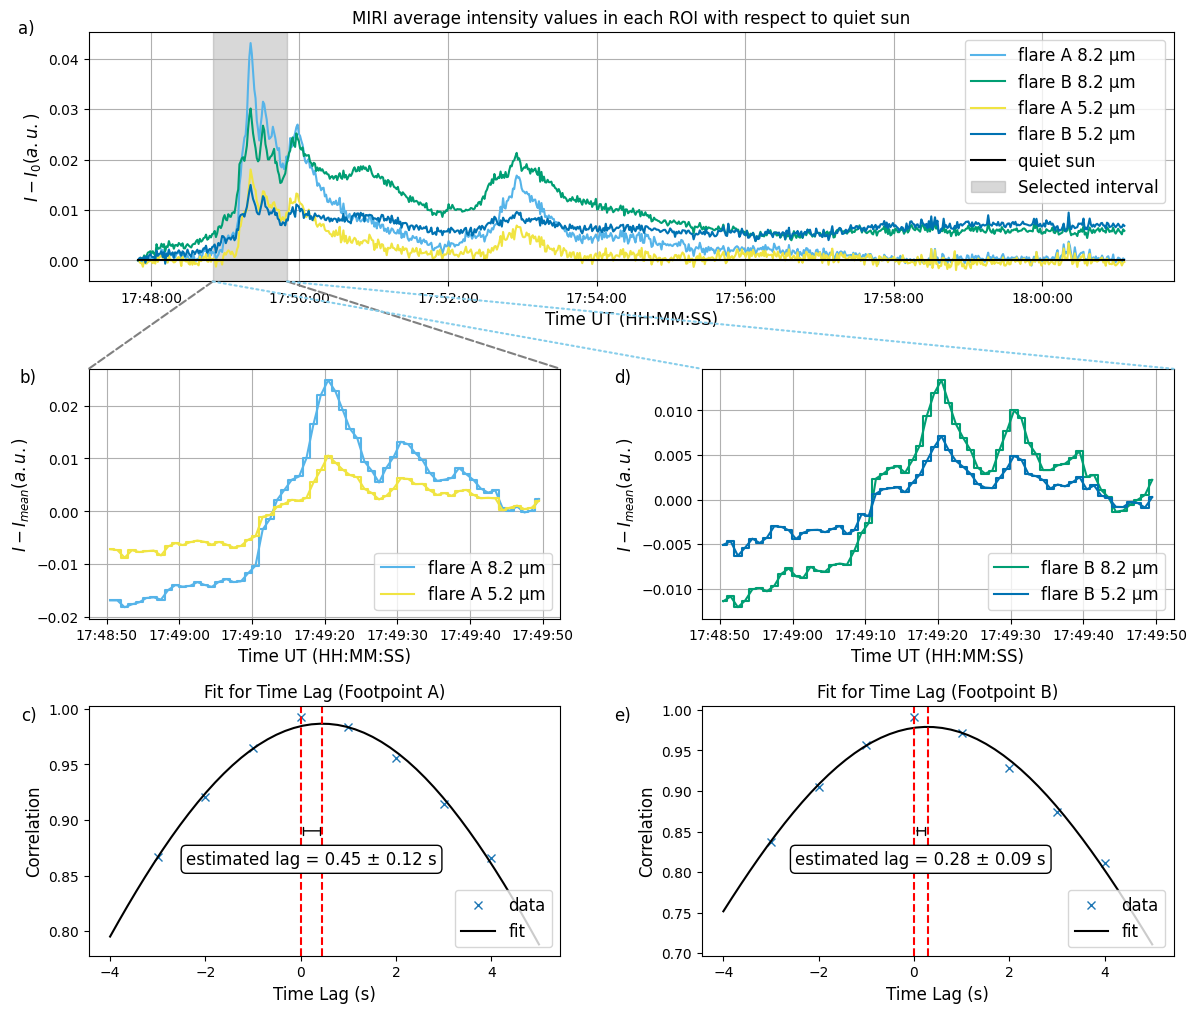

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.patches import ConnectionPatch


# --- Crear la figura y rejilla 2x3 ---
fig = plt.figure(figsize=(14, 12))
spec = gridspec.GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.3)

# ========== FILA 1 ==========
# Curvas de intensidad con sombreado
ax1 = fig.add_subplot(spec[0, :])  # ocupa toda la fila (colspan=2)

t1=datetime(2014,9,24,17,47,0)
p_t1 = min(enumerate(time_10), key=lambda x: abs(x[1] - t1))[0]

t2=datetime(2014, 9, 24, 18, 1, 7, 483000)
p_t2 = min(enumerate(time_10), key=lambda x: abs(x[1] - t2))[0]

t1_s = datetime(2014, 9, 24, 17, 48, 50)
t2_s = datetime(2014, 9, 24, 17, 49, 50)

ax1.set_title('MIRI average intensity values in each ROI with respect to quiet sun')
ax1.set_xlabel('Time UT (HH:MM:SS)', fontsize=12)
ax1.set_ylabel(r'$I-I_0  (a.u.)$', fontsize=12)

ax1.plot(time_10[p_t1:p_t2],
         np.subtract(fA_I_10-fA_I_10[0], qs_I_10-qs_I_10[0])[p_t1:p_t2],
         color=palette[2], label='flare A 8.2 µm')
ax1.plot(time_10[p_t1:p_t2],
         np.subtract(fB_I_10-fB_I_10[0], qs_I_10-qs_I_10[0])[p_t1:p_t2],
         color=palette[3], label='flare B 8.2 µm')

ax1.plot(time_05[p_t1:p_t2],
         np.subtract(fA_I_05-fA_I_05[0], qs_I_05-qs_I_05[0])[p_t1:p_t2],
         color=palette[4], label='flare A 5.2 µm')
ax1.plot(time_05[p_t1:p_t2],
         np.subtract(fB_I_05-fB_I_05[0], qs_I_05-qs_I_05[0])[p_t1:p_t2],
         color=palette[5], label='flare B 5.2 µm')

ax1.plot(time_05[p_t1:p_t2],
         np.subtract(qs_I_05-qs_I_05[0], qs_I_05-qs_I_05[0])[p_t1:p_t2],
         color=palette[0], label='quiet sun')

ax1.axvspan(t1_s, t2_s, color='gray', alpha=0.3, label='Selected interval')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
ax1.tick_params(axis='x', rotation=0)
ax1.grid(True)
ax1.legend(fontsize=12, loc='upper right')

# ========== COLUMNA IZQUERDA (FOOTPOINT A) ==========
t1=datetime(2014,9,24,17,48,50) #the initial date of the time series is 2014, 9, 24, 17, 47, 49, 483000
p_t1 = min(enumerate(time_10), key=lambda x: abs(x[1] - t1))[0] #find the position of the closer index given a date

t2=datetime(2014, 9, 24, 17, 49, 50, 0) #the final date of the time series is 2014, 9, 24, 18, 1, 7, 483000
p_t2 = min(enumerate(time_10), key=lambda x: abs(x[1] - t2))[0] #find the position of the closer index given a date

Int_1=np.subtract(fA_I_10-fA_I_10[0],qs_I_10-qs_I_10[0])[p_t1:p_t2]
Int_2=np.subtract(fA_I_05-fA_I_05[0],qs_I_05-qs_I_05[0])[p_t1:p_t2]
t=time_10[p_t1:p_t2]

mean_Int_1=np.average(Int_1)
mean_Int_2=np.average(Int_2)

#Correlation function
Norm=np.std(Int_1)*np.std(Int_2)*len(Int_1)
ns_1=4#Number of seconds to consider in the fit
ns_2=5
st=1 #time step size in seconds

correlation = TlocalCCF(Int_1, Int_2)

k=len(Int_1)
lags = np.arange(-k+3, k-2, 1)

x=lags[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]*st
y=correlation[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]

n = len(x)                          #the number of data
mean = sum(x*y)/n
sigma = sum(y*(x-mean)**2)/n
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

#Fitting
popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

# ====================
# Columna izquierda: Curva intensidad Flare A
ax4 = fig.add_subplot(spec[1, 0])
ax4.set_xlabel('Time UT (HH:MM:SS)', fontsize=12)
ax4.set_ylabel(r'$I-I_{mean}  (a.u.)$', fontsize=12)
ax4.plot(t, Int_1-mean_Int_1, color=palette[2], label='flare A 8.2 µm')
ax4.step(t, Int_1-mean_Int_1, color=palette[2], where='mid')
ax4.plot(t, Int_2-mean_Int_2, color=palette[4], label='flare A 5.2 µm')
ax4.step(t, Int_2-mean_Int_2, color=palette[4], where='mid')
ax4.grid(True)
ax4.legend(fontsize=12, loc='lower right')

# Columna izquierda: Fit point A
ax2 = fig.add_subplot(spec[2, 0])
ax2.plot(x, y, 'x', label='data')
x_ls = np.linspace(-ns_1, ns_2, num=50)
ax2.plot(x_ls, gaus(x_ls, *popt), color=palette[0], label='fit')
ax2.axvline(0, color='r', linestyle='--')
ax2.axvline(popt[1], color='r', linestyle='--')

# Crear un bracket (con FancyBracket o FancyArrowPatch tipo corchete)
bracket = mpatches.FancyArrowPatch(
    (0, 0.5), (popt[1], 0.5),  # coordenadas inicial y final en X
    transform=ax2.get_xaxis_transform(),  # relativo al eje X
    arrowstyle='|-|,widthA=0.2,widthB=0.2',  # estilo de bracket
    mutation_scale=15,  # tamaño de la llave
    color="black"
)
ax2.add_patch(bracket)


x_middle = (0 + popt[1]) / 2
ax2.text(
    x_middle, 0.35, f"estimated lag = {popt[1]:.2f} ± {lag_sigma_A:.2f} s",
    ha="center", va="bottom",
    transform=ax2.get_xaxis_transform(), fontsize=12,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
)
ax2.set_title('Fit for Time Lag (Footpoint A)')
ax2.set_xlabel('Time Lag (s)', fontsize=12)
ax2.set_ylabel('Correlation', fontsize=12)
ax2.legend(fontsize=12, loc='lower right')

# ========== COLUMNA DERECHA (FOOTPOINT B) ==========
Int_1=np.subtract(fB_I_10-fB_I_10[0],qs_I_10-qs_I_10[0])[p_t1:p_t2]
Int_2=np.subtract(fB_I_05-fB_I_05[0],qs_I_05-qs_I_05[0])[p_t1:p_t2]
t=time_10[p_t1:p_t2]

mean_Int_1=np.average(Int_1)
mean_Int_2=np.average(Int_2)

#Correlation function
Norm=np.std(Int_1)*np.std(Int_2)*len(Int_1)
ns_1=4#Number of seconds to consider in the fit
ns_2=5
st=1 #time step size in seconds

correlation = TlocalCCF(Int_1, Int_2)

k=len(Int_1)
lags = np.arange(-k+3, k-2, 1)

x=lags[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]*st
y=correlation[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]

n = len(x)                          #the number of data
mean = sum(x*y)/n
sigma = sum(y*(x-mean)**2)/n

#Fitting
popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

# ====================
# Columna derecha: Curva intensidad Flare B
ax3 = fig.add_subplot(spec[1, 1])
ax3.set_xlabel('Time UT (HH:MM:SS)', fontsize=12)
ax3.set_ylabel(r'$I-I_{mean}  (a.u.)$', fontsize=12)
ax3.plot(t, Int_1-mean_Int_1, color=palette[3], label='flare B 8.2 µm')
ax3.step(t, Int_1-mean_Int_1, color=palette[3], where='mid')
ax3.plot(t, Int_2-mean_Int_2, color=palette[5], label='flare B 5.2 µm')
ax3.step(t, Int_2-mean_Int_2, color=palette[5], where='mid')
ax3.grid(True)
ax3.legend(fontsize=12, loc='lower right')

# Columna derecha: Fit point B
ax5 = fig.add_subplot(spec[2, 1])
ax5.plot(x, y, 'x', label='data')
x_ls = np.linspace(-ns_1, ns_2, num=50)
ax5.plot(x_ls, gaus(x_ls, *popt), color=palette[0], label='fit')
ax5.axvline(0, color='r', linestyle='--')
ax5.axvline(popt[1], color='r', linestyle='--')

# Crear un bracket (con FancyBracket o FancyArrowPatch tipo corchete)
bracket = mpatches.FancyArrowPatch(
    (0, 0.5), (popt[1], 0.5),  # coordenadas inicial y final en X
    transform=ax5.get_xaxis_transform(),  # relativo al eje X
    arrowstyle='|-|,widthA=0.2,widthB=0.2',  # estilo de bracket
    mutation_scale=15,  # tamaño de la llave
    color="black"
)
ax5.add_patch(bracket)

# Agregar texto centrado entre las dos líneas
x_middle = (0 + popt[1]) / 2
ax5.text(
    x_middle, 0.35, f"estimated lag = {popt[1]:.2f} ± {lag_sigma_B:.2f} s",
    ha="center", va="bottom",
    transform=ax5.get_xaxis_transform(), fontsize=12,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
)

ax5.set_title('Fit for Time Lag (Footpoint B)')
ax5.set_xlabel('Time Lag (s)', fontsize=12)
ax5.set_ylabel('Correlation', fontsize=12)
ax5.legend(fontsize=12, loc='lower right')

#---------------Conexiones ------------------------#

# Punto de origen en ax1: (t1_s, ymin de ax1)
x0 = mdates.date2num(t1_s)
y0 = ax1.get_ylim()[0]
# Punto de destino en ax4: esquina superior izquierda
x1 = ax4.get_xlim()[0]
y1 = ax4.get_ylim()[1]

con1 = ConnectionPatch(
    xyA=(x0, y0), coordsA=ax1.transData,
    xyB=(x1, y1), coordsB=ax4.transData,
    linestyle="--", color="gray", lw=1.5
)
fig.add_artist(con1)

# Punto de origen en ax1: (t2_s, ymin de ax1)
x0 = mdates.date2num(t2_s)
y0 = ax1.get_ylim()[0]
# Punto de destino en ax4: esquina superior derecha
x1 = ax4.get_xlim()[1]
y1 = ax4.get_ylim()[1]

con2 = ConnectionPatch(
    xyA=(x0, y0), coordsA=ax1.transData,
    xyB=(x1, y1), coordsB=ax4.transData,
    linestyle="--", color="gray", lw=1.5
)
fig.add_artist(con2)

# Punto de origen en ax1: (t2_s, ymin de ax1)
x0 = mdates.date2num(t2_s)
y0 = ax1.get_ylim()[0]
# Punto de destino en ax3: esquina superior derecha
x1 = ax3.get_xlim()[1]
y1 = ax3.get_ylim()[1]

con3 = ConnectionPatch(
    xyA=(x0, y0), coordsA=ax1.transData,
    xyB=(x1, y1), coordsB=ax3.transData,
    linestyle=":", color="skyblue", lw=1.5
)
fig.add_artist(con3)

# Punto de origen en ax1: (t1_s, ymin de ax1)
x0 = mdates.date2num(t1_s)
y0 = ax1.get_ylim()[0]
# Punto de destino en ax3: esquina superior izquierda
x1 = ax3.get_xlim()[0]
y1 = ax3.get_ylim()[1]

con4 = ConnectionPatch(
    xyA=(x0, y0), coordsA=ax1.transData,
    xyB=(x1, y1), coordsB=ax3.transData,
    linestyle=":", color="skyblue", lw=1.5
)
fig.add_artist(con4)
# ------- Etiquetas de panel ------------------------------

ax1.text(-0.05, 1.05, 'a)', transform=ax1.transAxes, fontsize=12, va='top', ha='right')
ax4.text(-0.11, 1.0, 'b)', transform=ax4.transAxes, fontsize=12, va='top', ha='right')
ax2.text(-0.11, 1.0, 'c)', transform=ax2.transAxes, fontsize=12, va='top', ha='right')
ax3.text(-0.15, 1.0, 'd)', transform=ax3.transAxes, fontsize=12, va='top', ha='right')
ax5.text(-0.15, 1.0, 'e)', transform=ax5.transAxes, fontsize=12, va='top', ha='right')

# --- Guardar y mostrar ---
plt.tight_layout()

plt.show()


## Infrared emission during a solar flare

To model infrared emission during a solar flare, we consider the radiative transfer equation, whose general solution is given by:

\begin{equation}
I_\nu(s_0) = \int_{0}^{s_0} j_\nu(s) \exp\left[-\int_s^{s_0} k_\nu(s') \, \mathrm{d}s'\right] \mathrm{d}s,
\end{equation}

Where $I_\nu(s_0)$ is the specific intensity of the radiation emitted at the frequency $\nu$ observed at position $s_0$, $j_\nu$ is the emission coefficient, and $k_\nu$ is the absorption coefficient. This expression accounts for the contribution of each layer (at a height $s$) along the line of sight to the observed intensity, assuming the observer is located at $s_0$ and integrating from deeper atmospheric layers towards the observer, In our case, for the F-CHROMA grid results, zero is considered from 90 Km below the height of $\tau_{500 \mathrm{~nm}}=1$ (See Carlsson et all 2023 reference in the paper).

Considering the definition of the optical depth
\begin{equation}
\tau_\nu(s)=\int_s^{s_0}  k_v\left(s^{\prime}\right) \mathrm{d} s^{\prime}   ,
\end{equation}

and the definition of the contribution function (CF) as:

\begin{equation}
CF(s)= j_{\nu} e^{- \tau_\nu(s) }.
\end{equation}

Then:
\begin{equation}
I_\nu\left(s_0\right)=\int_{0}^{s_0} CF(s) \mathrm{d} s.
\end{equation}

This equation states that the intensity at $s_0$ is composed of the energy carried by photons emitted from all locations in front of $s_0$ that have not been absorbed or scattered into other directions on the way to the observer.

The source function can be equal to the Bolometric-Planckian equation, or (in the infrared region) the Rayleigh-Jeans equation.

\begin{equation}
j_{\nu} = k_\nu B_\nu.
\end{equation}

In the formation of the infrared continuum, the continuum-source function is given by the local Planck function $S_v=B_v(T)$, with $T$ being the kinetic (or electron temperature).

\begin{equation}
  B_\nu(\nu, T)=\frac{2 h \nu^3}{c^2} \cdot \frac{1}{e^{\frac{h \nu}{k_{\mathrm{B}} T}}-1} .
\end{equation}

According to \cite{Heinzel2012Optical-to-radioFlares} and references there, in the chromosphere, the main source of opacity for the infrared continuum is ion-free-free continuum, and in the temperature minimum region and below, the opacity is dominated by neutral free-free opacity.

As sated in the paper, we are following here the process described by Simoes et al (2017), you can see the paper for the reference.

The ion free-free $k_\nu(\mathrm{H})$ absorption coefficient (in ${cm}^{-1}$) can be written as:

\begin{equation}
k_\nu(\mathrm{H})=3.7 \times 10^8 T^{-1 / 2} n_{\mathrm{e}} n_p \nu^{-3} g_{\mathrm{ff}},   
\end{equation}

Where $n_{\mathrm{e}}$ and $n_p$ are the electron and proton densities respectively,  $T$ is the kinetic (or electron) temperature,  and $g_{\mathrm{ff}}$ is the Gaunt factor,  which is calculated using a bilinear interpolation of the factors calculated in Table 3 of VanHoof et al. (2014) paper (see reference in the paper). The $n_e$ includes contributions from hydrogen, helium, and metals.

In the lower atmosphere, around the temperature minimum region and below, H$^{-}$ (the negative hydrogen ion) free-free opacity dominates, and this can be calculated as:

\begin{equation}
k_\nu\left(\mathrm{H}^{-}\right)=\frac{n_{\mathrm{e}} n_{\mathrm{H}}}{\nu}\left(A_1+\left(A_2-A_3 / T\right) / \nu\right),
\end{equation}

Where $n_{\mathrm{H}}$ is the neutral hydrogen density, and the numerical coefficients are $A_1=1.3727 \times 10^{-25}, A_2=4.3748 \times 10^{-10}$, and $A_3=2.5993 \times 10^{-7}$.

Finally, the total absorption coefficient is:
\begin{equation}
k_\nu=\left[\kappa_v(\mathrm{H})+\kappa_v\left(\mathrm{H}^{-}\right)\right]\left(1-e^{-h v / k_{\mathrm{b}} T}\right)    
\end{equation}
with the term $\left(1-e^{-h \nu / k_b T}\right)$ being the correction for stimulated emission, where $h$ and $k_{\mathrm{b}}$ are the Planck and Boltzmann constants.

### Infrared emission during a solar flare from a RADYN output

You can use the following two lines if you have the RADYN F-CHROMA grid output file (available at https://star.pst.qub.ac.uk/wiki/public/solarmodels/start.html).
See the reference Carlsson et al. 2023 in the paper.

In [41]:
#from radynpy.cdf import LazyRadynData
#data = LazyRadynData(r"PathToRADYNOutput")

In [42]:
##This shows the number of time steps (there are 501 time steps in RADYN F-CHROMA outputs)
#times_1=data.time
##proton density for each time and height (there are 300 height steps in RADYN F-CHROMA outputs)
#proton_density=data.n1[:,:,5,0]
##hydrogen density for each time and height
#hydrogen_density=data.n1[:,:,0,0]+data.n1[:,:,1,0]+data.n1[:,:,2,0]+data.n1[:,:,3,0]+data.n1[:,:,4,0]
##Electron density for each time and height
#electron_density=data.ne1
##temperture  for each time and height (es la temperatura de los electrones)
#temperature= data.tg1
##Values of height in cm for each time (data.z1[t,k])
#height_array=data.z1

Alternatively, you can use the already processed files for the cases used in the paper. These files contain the subset of RADYN outputs necessary for calculating infrared emission, i.e:
*   the times (in seconds) since the begining of the energy input.
*   the proton, hydrogen and electron density for each time and height (particles per cubic centimeters).
*   the electron temperature (in Kelvins)
*   the values of heights at each time (in centimeters).




In [43]:
# Load variables from the pickle file
with open(f'{folder}/RADYN_Outputs_FChromaGrid/radyn_out.val3c_d3_1.0e11_t20s_15kev_fp_processed.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# variables from the pickle file
times_1 = loaded_data['times_1']
proton_density = loaded_data['proton_density']
hydrogen_density = loaded_data['hydrogen_density']
electron_density = loaded_data['electron_density']
temperature = loaded_data['temperature']
height_array = loaded_data['height_array']

The following code allows you to create an animation to visualize the density and temperature values ​​as a function of height for each of the time instants.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(8, 4))
ax2 = ax.twinx()

def animate(n):
    ax.cla()
    ax2.cla()

    x = (height_array[n, :] - np.min(height_array[n, :])) / 1e8
    y = proton_density[n, :]
    y2 = hydrogen_density[n, :]
    y3 = electron_density[n, :]
    y_temp = temperature[n, :]

    #Left: Density
    ax.set_yscale('log')
    ax.set_xlabel('Depth (Mm)')
    ax.set_ylabel('Density (cm^3)')
    ax.plot(x, y,  lw=2, marker='o', color='b', markersize=3, label="proton")
    ax.plot(x, y2, lw=2, marker='o', color='r', markersize=3, label="hydrogen")
    ax.plot(x, y3, lw=2, marker='o', color='g', markersize=3, label="electron")
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(hydrogen_density.min(), hydrogen_density.max())
    ax.legend(loc='lower right')
    ax.set_title(f'Density and Temperature for t = {n*0.1:.3f}s')

    # Right: Temperature
    ax2.set_yscale('log')
    ax2.set_ylabel('Temperature (K)')
    ax2.plot(x, y_temp, lw=2, color='orange', label='Temperature')
    ax2.set_ylim(temperature.min(), temperature.max())
    ax2.set_xlim(np.min(x), np.max(x))
    ax2.legend(loc='upper right')

ani1 = FuncAnimation(fig, animate, frames=range(500), interval=100)
plt.close()

HTML(ani1.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

This segment defines the gaunt factor interpolation

In [45]:

# Table axis
log_u = np.array([-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=float)
log_y2 = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4], dtype=float)

# Matrix values for Gaunt factor from  P. A. M. van Hoof, 2014
values = np.array([
    [1.0601e+1, 1.0598e+1, 1.0573e+1, 1.0449e+1, 1.0073e+1, 9.4852e+0, 8.8548e+0, 8.2207e+0, 7.5863e+0],
    [9.3319e+0, 9.3280e+0, 9.3033e+0, 9.1795e+0, 8.8036e+0, 8.2160e+0, 7.5859e+0, 6.9524e+0, 6.3194e+0],
    [8.0624e+0, 8.0586e+0, 8.0340e+0, 7.9103e+0, 7.5347e+0, 6.9477e+0, 6.3190e+0, 5.6882e+0, 5.0660e+0],
    [6.7931e+0, 6.7894e+0, 6.7651e+0, 6.6421e+0, 6.2678e+0, 5.6835e+0, 5.0601e+0, 4.4399e+0, 3.8322e+0],
    [5.5243e+0, 5.5213e+0, 5.4983e+0, 5.3780e+0, 5.0091e+0, 4.4354e+0, 3.8318e+0, 3.2474e+0, 2.7008e+0],
    [4.2581e+0, 4.2577e+0, 4.2402e+0, 4.1307e+0, 3.7818e+0, 3.2438e+0, 2.7011e+0, 2.2128e+0, 1.8041e+0],
    [3.0049e+0, 3.0125e+0, 3.0153e+0, 2.9436e+0, 2.6563e+0, 2.2134e+0, 1.8072e+0, 1.4932e+0, 1.2769e+0],
    [1.8154e+0, 1.8368e+0, 1.8882e+0, 1.9244e+0, 1.7826e+0, 1.5086e+0, 1.2884e+0, 1.1506e+0, 1.0743e+0],
    [8.5319e-1, 8.8158e-1, 9.6976e-1, 1.1697e+0, 1.2937e+0, 1.1987e+0, 1.1033e+0, 1.0502e+0, 1.0237e+0],
    [3.1011e-1, 3.2829e-1, 3.8999e-1, 5.8929e-1, 9.7260e-1, 1.1285e+0, 1.0825e+0, 1.0420e+0, 1.0202e+0],
    [1.0069e-1, 1.0796e-1, 1.3352e-1, 2.2811e-1, 5.1717e-1, 9.5609e-1, 1.1065e-0, 1.0693e-0, 1.0355e+0],
    [3.1978e-2, 3.4445e-2, 4.3211e-2, 7.7180e-2, 1.9973e-1, 5.1461e-1, 9.5479e-1, 1.1042e+0, 1.0680e+0],
    [1.0121e-1, 1.0918e-2, 1.3760e-2, 2.4936e-2, 6.7503e-2, 1.9870e-1, 5.1462e-1, 9.5466e-1, 1.1040e+0],
    [3.2014e-3, 3.4550e-3, 4.3608e-3, 7.9393e-3, 2.1807e-2, 6.7151e-2, 1.9870e-1, 5.1462e-1, 9.5465e-1],
    [1.0124e-3, 1.0928e-3, 1.3799e-3, 2.5160e-3, 6.9428e-3, 2.1693e-2, 6.7151e-2, 1.9870e-1, 5.1462e-1],
    [3.0747e-4, 3.4560e-4, 4.3647e-4, 7.9618e-4, 2.2002e-3, 6.9065e-3, 2.1693e-2, 6.7151e-2, 1.9870e-1],
    [1.0125e-4, 1.0929e-4, 1.3803e-4, 2.5183e-4, 6.9624e-4, 2.1887e-3, 6.9065e-3, 2.1693e-2, 6.7151e-2],
])

# 2D interpolator using bilinear GridInterpolator
interp_func = RegularGridInterpolator((log_u, log_y2), values)

# Physical constants
#h = const.h # PlancK's constant (6.62607015e-34 J s)
h = 6.62607015e-27 #erg s
#Kb = const.K # Boltzmann constant (1.380649e-23 J/K)
Kb = 1.380649e-16 #erg K-1
#Ry = 2.17987e-18 J
Ry = 2.17987e-18*1e7 #erg

def gaunt(nu, T):
    """
    Compute the Gaunt factor for hydrogen using the interpolation table
    from van Hoof (2014, Table 3).
    The paper P. A. M. van Hoof, 2014, considers the definition of two dimensionless parameters, gamma squared (y2) and u to show the dependence
    of the Gaunt factor on the frequency and the electronic temperature, see eq 21 and table 3. (it also depends on the atomic number which in this case is 1)
    Parameters
    ----------
    nu : float
        Frequency [Hz]
    T : float or array-like
        Electron temperature [K]

    Returns
    -------
    g_ff : float
        Interpolated Gaunt factor.
    """
    # Convert T to numpy array
    T = np.atleast_1d(T)

    # Compute dimensionless parameters
    y2 = Ry / (Kb * T)   # gamma^2
    u = (h * nu) / (Kb * T)

    # Logarithmic coordinates
    log_u = np.log10(u)
    log_y2 = np.log10(y2)

    # Prepare coordinates for interpolation
    points = np.column_stack((log_u, log_y2))

    # Interpolate
    result = interp_func(points)

    # Return scalar if input was scalar
    return result if T.ndim > 0 else result.item()

#test
#gaunt(3e13,temperature[0, :])
#gaunt(3e13,15788734)


This segment defines the functions mentioned above for calculating the average infrared emission.

In [46]:
#Functions to calculate K_nu_H, K_nu_H_minus and total_K_nu

# Physical constants (SI and cgs)
#e = const.e # electron charge (1.602176634e-19 C)
e = 4.803250e-10 #ESU
#m = const.m_e # electron mass (9.10938356e-31 Kg)
m = 9.109558e-28 #g
#h = const.h # PlancK's constant (6.62607015e-34 J s)
h = 6.62607015e-27 #erg s
#c = const.c # speed of light (299792458 m/s)
c = 29979245800 #cm/s
#Kb = const.K # Boltzmann constant (1.380649e-23 J/K)
Kb = 1.380649e-16 #erg K-1
pi = const.pi # π (3.141592653589793)
cte = ((4*e**6)/(3*m*h*c)) * ((2*pi)/(3*Kb*m))**0.5
cte = (3.7e8)
def K_nu_H(T,n_e, n_p,nu):
    """
    Calculate the absorption coefficient for H

    Parameters:
    T (float): temperature [K]
    n_e (float): electron density [cm^-3]
    n_p (float): proton density [cm^-3]
    nu (float): frequency [Hz]

    Returns:
    float: absorption coefficient K_nu(H-) [cm^-1]
    """
    #g_ff=1 #Gaunt factor
    g_ff=gaunt(nu,T)

    K_nu_H=(cte)*T**(-1/2)*n_e*n_p*nu**(-3)*g_ff
    return K_nu_H

def K_nu_H_minus(n_e, n_H, nu, T):
    """
    Calculate the absorption coefficient for H-

    Parameters:
    n_e: electron density [cm^-3]
    n_H: neutral hydrogen density [cm^-3]
    nu: frequency [Hz]
    T : temperature [K]

    Returns:
    float: absorption coefficient K_nu(H-) [cm^-1]
    """
    A1 = 1.3727e-25 #units?
    A2 = 4.3748e-10 #units?
    A3 = 2.5993e-7  #units?

    K_nu_H_minus = (n_e*n_H/nu) * (A1+ ((A2-A3/T)/nu))
    return K_nu_H_minus


def total_K_nu(K_nu_H, K_nu_H_minus, nu, T):
    """
    Calculate the total absorption coefficient including stimulated emission correction.

    Parameters:
    K_nu_H: absorption coefficient from neutral hydrogen [cm^-1]
    K_nu_H_minus: absorption coefficient from H- [cm^-1]
    nu: frequency [Hz]
    T: temperature [K]

    Returns:
    float: total absorption coefficient with stimulated emission correction [cm^-1]
    """

    # Stimulated emission correction term
    stimulated_emission_correction = 1 - np.exp((-h*nu)/(Kb*T))

    # Total absorption coefficient
    total_K_nu = (K_nu_H + K_nu_H_minus)*stimulated_emission_correction

    return total_K_nu

def total_K_nu_H_minus(K_nu_H_minus, nu, T):
    """
    Calculate the total absorption coefficient for H minus including stimulated emission correction.

    Parameters:
    K_nu_H_minus: absorption coefficient from H- [cm^-1]
    nu: frequency [Hz]
    T: temperature [K]

    Returns:
    float: total absorption coefficient with stimulated emission correction [cm^-1]
    """

    # Stimulated emission correction term
    stimulated_emission_correction = 1 - np.exp((-h*nu)/(Kb*T))

    # Total absorption coefficient
    total_K_nu = (K_nu_H_minus)*stimulated_emission_correction

    return total_K_nu

def total_K_nu_H(K_nu_H, nu, T):
    """
    Calculate the total absorption coefficient for H including stimulated emission correction.

    Parameters:
    K_nu_H: absorption coefficient from neutral hydrogen [cm^-1]
    nu: frequency [Hz]
    T: temperature [K]

    Returns:
    float: total absorption coefficient with stimulated emission correction [cm^-1]
    """

    # Stimulated emission correction term
    stimulated_emission_correction = 1 - np.exp((-h*nu)/(Kb*T))

    # Total absorption coefficient
    total_K_nu = (K_nu_H)*stimulated_emission_correction

    return total_K_nu


def B_nu(nu, T):
    """
    Calculate the spectral radiance of a blacKbody using PlancK's law.

    Parameters:
    nu: Frequency [Hz]
    T : Temperature [K]

    Returns:
    Spectral radiance [W·sr^-1·m^-2·Hz^-1] or in cgs [erg^-1 sr^-1 cm^-2 Hz^-1]
    """

    B_nu = (2*h*nu**3/c**2)/(np.exp((h*nu)/(Kb*T)) - 1)

    return B_nu

def tau_nu(K_nu_array, height_array, i_s0):
    """
    Calculate optical depth from a position s to a height s0 = 10Mm (where the observer is located),
    In RADYN we asume the observer is at 10Mm, and there are 300 steps between 0Mm and 10Mm.
    The integral is estimated as the discrete sum of all the K_nu(s)*ds terms added.

    Parameters:
    K_nu_array: Total absorption coefficient array (K_nu at each position between 0 and 10Mm)
    i_s0 : index of the height at which the optical depth is calculated, It has to be between 0 and 299.

    Returns:
    Optical depth in a given position s [units?]
    """
    tau_nu=0
    ds = np.diff(height_array)               # delta h_i = h_{i+1} - h_i
    K_nu_array_left = K_nu_array[:-1]              # use left values for the Riemann sum
    tau_nu = np.sum(K_nu_array_left[0:i_s0] * ds[0:i_s0])        # sum_i CF(h_i) * delta_h_i
    tau_nu= -tau_nu

    return tau_nu

def tau_nu2(K_nu_array, height_array, i_s0):
    """
    Calculate optical depth from a position s to a height s0 = 10Mm (where the observer is located),
    In RADYN we asume the observer is at 10Mm, and there are 300 steps between 0Mm and 10Mm.

    Parameters:
    K_nu_array: Total absorption coefficient array (K_nu at each position between 0 and 10Mm)
    i_s0 : index of the height at which the optical depth is calculated, It has to be between 0 and 299.

    Returns:
    Optical depth in a given position s [units?]
    """
    tau_nu=0
    tau_nu = integrate.trapezoid(K_nu_array[0:(i_s0)],x=height_array[0:(i_s0)]) # For a better approximation, the trapezoidal approximation of the integral is used here.
    tau_nu= -tau_nu
    return tau_nu

def CF(K_nu, B_nu, tau_nu):
    """
    Calculate the contribution function at a position "s" that is determined by the value of tau_nu given to it.

    Parameters:
    K_nu: Total absorption coefficient at each s. [cm-1]
    B_nu: Spectral radiance of a blacKbody using PlancK's law [erg^-1 sr^-1 cm^-2 Hz^-1] at each s.
    tau_nu: Optical depth at each s.

    Returns:
    Contribution function at a position each "s" [erg^-1 sr^-1 cm^-3 Hz^-1]
    """

    j_nu= K_nu*B_nu
    CF=j_nu*np.exp(-1*np.array(tau_nu))

    return CF

def Intensity(CF_nu_array, height_array):
    """
    Calculate the intensity using a left Riemann sum.

    Parameters:
    CF_nu_array: Array of contribution function values (same shape as height_array)
    height_array: Array of heights (in cm), not necessarily uniform, 300 values from 0 to 10 Mm

    Returns:
    Integrated intensity over height (in [units of CF_nu * cm])
    """
    ds = np.diff(height_array)              # delta h_i = h_{i+1} - h_i
    CF_left = CF_nu_array[:-1]              # use left values for the Riemann sum
    intensity = np.sum(CF_left * ds)        # sum_i CF(h_i) * delta_h_i
    intensity = -intensity
    return intensity

def Intensity2(CF_nu_array, height_array):
    """
    Calculate the intensity.
    In RADYN we assume the observer is at 10Mm, and there are 300 steps between 0Mm and 10Mm.
    The integral is estimated as the discrete sum (using the trapezoidal rule) of all the CF(s)*ds terms.

    Parameters:
    CF_nu_array: Array of contribution function values (same shape as height_array)
    height_array: Array of heights (in cm), not necessarily uniform, 300 values from 0 to 10 Mm

    Returns:
    Integrated intensity over height (in [units of CF_nu * cm])
    """
    return  -integrate.trapezoid(CF_nu_array, x=height_array)

def T_b(nu, Iv):
    """
    Calculates the brightness temperature T_b(nu) from the spectral intensity Iv and frequency nu.

    Parameters:
    nu : float
        Frequency in Hz.
    Iv : float
        Spectral intensity in [erg^-1 sr^-1 cm^-2 Hz^-1] or [W·m⁻²·Hz⁻¹·sr⁻¹].

    Returns:
    float
        Brightness temperature T_b in Kelvins (K).
    """
    nu = np.asarray(nu, dtype=float)
    Iv = np.asarray(Iv, dtype=float)

    Tb = (c**2 / (2 * Kb * nu**2)) * Iv
    return Tb


The previously defined functions are used in this segment to obtain intensity values ​​for two wavelengths (5.2 and 8.2 micrometers).

To obtain a better estimate of the integrals involved, an interpolation of 10 000 height points is first performed instead of the original 300 points provided by the RADYN outputs.

Finally, the intensity values ​​are plotted with respect to the initial value (excess emission) and  the lag is obtained as the difference between the times in which the maximum emission occurs in each wavelenght.

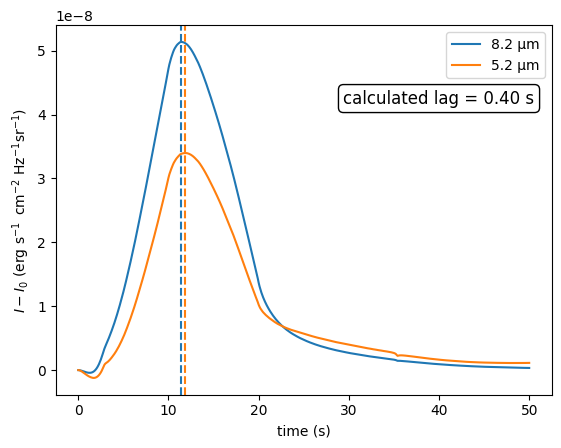

Initial intensity 8μm: 2.0560826628173623e-06 (erg*s^-1*cm^-2*Hz^-1*sr^-1)
Initial intensity 5μm: 4.917490203220184e-06 (erg*s^-1*cm^-2*Hz^-1*sr^-1)
time max intesnity 8um: 11.40s
time max intesnity 5um: 11.80s
Delay between max: 0.40s


In [47]:
#Variation of intensity in time

I_5um=[]
I_8um=[]

#time steps (goes from 0 to 501)
for n in range(501):
    N_puntos= 10000

    height_array_n = height_array[n, :]-np.min(height_array[n, :])
    height_array_inter=np.linspace(np.max(height_array_n), 0, N_puntos)

    # Parameters for each point in time (n) and space (i) taKen from RADYN
    n_e = electron_density[n, :]
    n_p = proton_density[n, :]
    n_H = hydrogen_density[n, :]
    T = temperature[n, :]

    #5um:
    nu = 5.765e+13  # frequency in Hz
    K_5um_H_values = K_nu_H(T, n_e, n_p, nu)
    K_5um_H_minus_values = K_nu_H_minus(n_e, n_H, nu, T)
    K_5um_values = total_K_nu(K_5um_H_values, K_5um_H_minus_values, nu, T)
    K_5um_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_5um_values)[::-1])[::-1])
    T2 = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(T)[::-1])[::-1])

    B_5um = B_nu(nu, T2)
    j_5um = K_5um_values*B_5um

    #FIRST INTGRATION
    tau_5um = -integrate.cumulative_trapezoid(K_5um_values, x=height_array_inter, initial=0)
    CF_5um= CF(K_5um_values, B_5um, tau_5um)

    #SECOND INTEGRATION
    I_5um_n = -integrate.trapezoid(CF_5um, x=height_array_inter)
    I_5um.append(I_5um_n)

    #8um:
    nu = 3.656e+13  # frequency
    K_8um_H_values = K_nu_H(T, n_e, n_p, nu)
    K_8um_H_minus_values = K_nu_H_minus(n_e, n_H, nu, T)
    K_8um_values = total_K_nu(K_8um_H_values, K_8um_H_minus_values, nu, T)
    K_8um_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_8um_values)[::-1])[::-1])

    B_8um = B_nu(nu, T2)
    j_8um = K_8um_values*B_8um

    #FIRST INTGRATION
    tau_8um = -integrate.cumulative_trapezoid(K_8um_values, x=height_array_inter, initial=0)
    CF_8um= CF(K_8um_values, B_8um, tau_8um)

    #SECOND INTEGRATION
    I_8um_n =  -integrate.trapezoid(CF_8um, x=height_array_inter)
    I_8um.append(I_8um_n)

T_5um = T_b(5.765e+13, I_5um)
T_8um = T_b(3.656e+13, I_8um)

#PLOT
plt.plot(times_1,(I_8um-I_8um[0]), label="8.2 µm", color='C0')
plt.plot(times_1,(I_5um-I_5um[0]), label="5.2 µm", color='C1')
max_height_8um = times_1[np.argmax(I_8um)]
max_height_5um = times_1[np.argmax(I_5um)]
delay_max= max_height_5um-max_height_8um
plt.axvline(x = max_height_8um,color='C0',linestyle='--')
plt.axvline(x = max_height_5um,color='C1',linestyle='--')
plt.xlabel('time (s)')
plt.ylabel(r"$I - I_{0}$ ($\operatorname{erg~s}^{-1} \mathrm{~cm}^{-2} \mathrm{~Hz}^{-1} \mathrm{sr}^{-1}$)")
plt.legend()

plt.text(max(times_1)*0.8, max(I_8um-I_8um[0])*0.8,
         f"calculated lag = {delay_max:.2f} s",
         ha="center", va="bottom", fontsize=12,
         bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"))

plt.show()

#PRINTS
delay_max= max_height_5um-max_height_8um
print(f"Initial intensity 8μm: {I_8um[0]} (erg*s^{-1}*cm^{-2}*Hz^{-1}*sr^{-1})")
print(f"Initial intensity 5μm: {I_5um[0]} (erg*s^{-1}*cm^{-2}*Hz^{-1}*sr^{-1})")
print(f"time max intesnity 8um: {max_height_8um:.2f}s")
print(f"time max intesnity 5um: {max_height_5um:.2f}s")
print(f"Delay between max: {delay_max:.2f}s")

### Contribution funtion at different times

This section of the code allows you to visualize the contribution function as a function of height for three specific times.

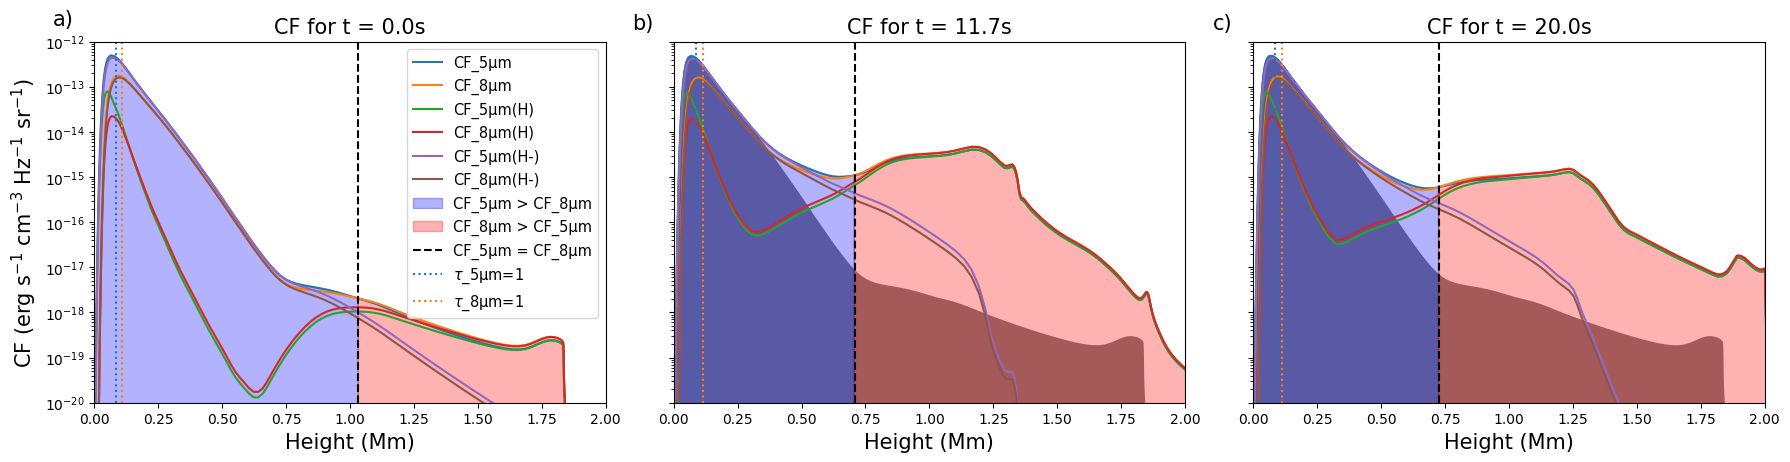

In [48]:
N_puntos = 10000
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# ===============================
# Panel 1: t = 0s (n=0)
# ===============================
n=0
#For each time step (n)
height_array_n = height_array[n, :]-np.min(height_array[n, :])
height_array_inter=np.linspace(np.max(height_array_n), 0, N_puntos)
#height_array_inter=height_array_n

# Parameters for each point in time (n) and space (i) taKen from RADYN
n_e = electron_density[n, :]
n_p = proton_density[n, :]
n_H = hydrogen_density[n, :]
T = temperature[n, :]

#5um:
nu = 5.765e+13  # frequency in Hz
ec_5um=(1 - np.exp((-h*nu)/(Kb*T)))
K_5um_H_values = K_nu_H(T, n_e, n_p, nu)*ec_5um
K_5um_H_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_5um_H_values)[::-1])[::-1])
K_5um_H_minus_values = K_nu_H_minus(n_e, n_H, nu, T)*ec_5um
K_5um_H_minus_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_5um_H_minus_values)[::-1])[::-1])
K_5um_values = K_5um_H_values + K_5um_H_minus_values
T2 = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(T)[::-1])[::-1])

B_5um = B_nu(nu, T2)
j_5um = K_5um_values*B_5um

tau_5um = -integrate.cumulative_trapezoid(K_5um_values, x=height_array_inter, initial=0)

CF_5um_H = CF(K_5um_H_values, B_5um, tau_5um)
CF_5um_H_minus = CF(K_5um_H_minus_values, B_5um, tau_5um)
CF_5um = CF(K_5um_values, B_5um, tau_5um)

I_5um_n = Intensity2(CF_5um,height_array_inter)

#8um:
nu = 3.656e+13  # frequency
#nu = 1e+13
ec_8um=(1 - np.exp((-h*nu)/(Kb*T)))
K_8um_H_values = K_nu_H(T, n_e, n_p, nu)*ec_8um
K_8um_H_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_8um_H_values)[::-1])[::-1])
K_8um_H_minus_values = K_nu_H_minus(n_e, n_H, nu, T)*ec_8um
K_8um_H_minus_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_8um_H_minus_values)[::-1])[::-1])
K_8um_values = K_8um_H_values + K_8um_H_minus_values

B_8um = B_nu(nu, T2)
j_8um = K_8um_values*B_8um

tau_8um = -integrate.cumulative_trapezoid(K_8um_values, x=height_array_inter, initial=0)

CF_8um_H = CF(K_8um_H_values, B_8um, tau_8um)
CF_8um_H_minus = CF(K_8um_H_minus_values, B_8um, tau_8um)
CF_8um= CF(K_8um_values, B_8um, tau_8um)

I_8um_n = Intensity2(CF_8um,height_array_inter)


# ---- Plot ----
ax = axes[0]
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um[0:N_puntos],label="CF_5μm", color='C0' )
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um[0:N_puntos],label="CF_8μm", color='C1' )

ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um_H[0:N_puntos],label=r"CF_5μm(H)", color='C2' )
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um_H[0:N_puntos],label=r"CF_8μm(H)", color='C3' )

ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um_H_minus[0:N_puntos],label=r"CF_5μm(H-)", color='C4' )
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um_H_minus[0:N_puntos],label=r"CF_8μm(H-)", color='C5' )

# Region where CF_5um > CF_8um
ax.fill_between(height_array_inter[0:N_puntos] / 1e8 , CF_5um[0:N_puntos], 0, where=(CF_5um[0:N_puntos] > CF_8um[0:N_puntos]), interpolate=True, color='blue', alpha=0.3, label=r"CF_5μm > CF_8μm")
# Region where CF_8um > CF_5um
ax.fill_between(height_array_inter[0:N_puntos] / 1e8 , CF_8um[0:N_puntos], 0, where=(CF_8um[0:N_puntos] >  CF_5um[0:N_puntos]), interpolate=True, color='red', alpha=0.3, label=r"CF_8μm > CF_5μm")

# Index where difference change sign
cross_index = np.where(np.diff(np.sign(CF_5um - CF_8um)))[0][0]

# vertical doted line
ax.axvline(height_array_inter[cross_index]/1e8, color='k', linestyle='--', label=r'CF_5μm = CF_8μm')

  # === Líneas verticales donde tau = 1 ===
# Buscar índice más cercano a tau = 1 para 5um
if np.any(tau_5um >= 1):
  idx_tau1_5um = np.where(tau_5um >= 1)[0][0]
  ax.axvline(height_array_inter[idx_tau1_5um]/1e8, color='C0', linestyle=':', label=r'$\tau$_5μm=1')

# Buscar índice más cercano a tau = 1 para 8um
if np.any(tau_8um >= 1):
  idx_tau1_8um = np.where(tau_8um >= 1)[0][0]
  ax.axvline(height_array_inter[idx_tau1_8um]/1e8, color='C1', linestyle=':', label=r'$\tau$_8μm=1')


ax.set_title(f'CF for t = {n*0.1:.1f}s', fontsize=15)
ax.set_xlabel('Height (Mm)', fontsize=15)
ax.set_ylabel(r'CF ($\mathrm{erg~s^{-1}~cm^{-3}~Hz^{-1}~sr^{-1}}$)', fontsize=15)
ax.set_yscale('log')
ax.set_ylim(1e-20, 1e-12)
ax.set_xlim(0,2)
# Etiqueta tipo panel
ax.text(-0.04, 1.09, "a)", transform=ax.transAxes, fontsize=15, va='top', ha='right')

# ===============================
# Panel 2: t = 3s (n=30)
# ===============================
n = 117
height_array_0 = height_array[0, :]-np.min(height_array[0, :])
height_array_inter_0=np.linspace(np.max(height_array_0), 0, N_puntos)

# Parameters for each point in time (n=0) and space (i) taKen from RADYN
n_e_0 = electron_density[0, :]
n_p_0 = proton_density[0, :]
n_H_0 = hydrogen_density[0, :]
T_0 = temperature[0, :]

#5um:
nu = 5.765e+13  # frequency in Hz
ec_5um_0=(1 - np.exp((-h*nu)/(Kb*T_0)))
K_5um_H_values_0 = K_nu_H(T_0, n_e_0, n_p_0, nu)*ec_5um_0
K_5um_H_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_5um_H_values_0)[::-1])[::-1])
K_5um_H_minus_values_0 = K_nu_H_minus(n_e_0, n_H_0, nu, T_0)*ec_5um_0
K_5um_H_minus_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_5um_H_minus_values_0)[::-1])[::-1])
K_5um_values_0 = K_5um_H_values_0 + K_5um_H_minus_values_0
T2_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(T_0)[::-1])[::-1])

B_5um_0 = B_nu(nu, T2_0)
j_5um_0 = K_5um_values_0*B_5um_0

tau_5um_0 = -integrate.cumulative_trapezoid(K_5um_values_0, x=height_array_inter_0, initial=0)

CF_5um_H_0 = CF(K_5um_H_values_0, B_5um_0, tau_5um_0)
CF_5um_H_minus_0 = CF(K_5um_H_minus_values_0, B_5um_0, tau_5um_0)
CF_5um_0 = CF(K_5um_values_0, B_5um_0, tau_5um_0)

#8um:
nu = 3.656e+13  # frequency
#nu = 1e+13
ec_8um_0=(1 - np.exp((-h*nu)/(Kb*T_0)))
K_8um_H_values_0 = K_nu_H(T_0, n_e_0, n_p_0, nu)*ec_8um_0
K_8um_H_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_8um_H_values_0)[::-1])[::-1])
K_8um_H_minus_values_0 = K_nu_H_minus(n_e_0, n_H_0, nu, T_0)*ec_8um_0
K_8um_H_minus_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_8um_H_minus_values_0)[::-1])[::-1])
K_8um_values_0 = K_8um_H_values_0 + K_8um_H_minus_values_0

B_8um_0 = B_nu(nu, T2_0)
j_8um_0 = K_8um_values_0*B_8um_0

tau_8um_0 = -integrate.cumulative_trapezoid(K_8um_values_0, x=height_array_inter_0, initial=0)

CF_8um_H_0 = CF(K_8um_H_values_0, B_8um_0, tau_8um_0)
CF_8um_H_minus_0 = CF(K_8um_H_minus_values_0, B_8um_0, tau_8um_0)
CF_8um_0= CF(K_8um_values_0, B_8um_0, tau_8um_0)

#For each time step (n)
height_array_n = height_array[n, :]-np.min(height_array[n, :])
height_array_inter=np.linspace(np.max(height_array_n), 0, N_puntos)
#height_array_inter=height_array_n

# Parameters for each point in time (n) and space (i) taKen from RADYN
n_e = electron_density[n, :]
n_p = proton_density[n, :]
n_H = hydrogen_density[n, :]
T = temperature[n, :]

#5um:
nu = 5.765e+13  # frequency in Hz
ec_5um=(1 - np.exp((-h*nu)/(Kb*T)))
K_5um_H_values = K_nu_H(T, n_e, n_p, nu)*ec_5um
K_5um_H_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_5um_H_values)[::-1])[::-1])
K_5um_H_minus_values = K_nu_H_minus(n_e, n_H, nu, T)*ec_5um
K_5um_H_minus_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_5um_H_minus_values)[::-1])[::-1])
K_5um_values = K_5um_H_values + K_5um_H_minus_values
T2 = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(T)[::-1])[::-1])

B_5um = B_nu(nu, T2)
j_5um = K_5um_values*B_5um

tau_5um = -integrate.cumulative_trapezoid(K_5um_values, x=height_array_inter, initial=0)

CF_5um_H = CF(K_5um_H_values, B_5um, tau_5um)
CF_5um_H_minus = CF(K_5um_H_minus_values, B_5um, tau_5um)
CF_5um = CF(K_5um_values, B_5um, tau_5um)

#8um:
nu = 3.656e+13  # frequency
#nu = 1e+13
ec_8um=(1 - np.exp((-h*nu)/(Kb*T)))
K_8um_H_values = K_nu_H(T, n_e, n_p, nu)*ec_8um
K_8um_H_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_8um_H_values)[::-1])[::-1])
K_8um_H_minus_values = K_nu_H_minus(n_e, n_H, nu, T)*ec_8um
K_8um_H_minus_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_8um_H_minus_values)[::-1])[::-1])
K_8um_values = K_8um_H_values + K_8um_H_minus_values

B_8um = B_nu(nu, T2)
j_8um = K_8um_values*B_8um

tau_8um = -integrate.cumulative_trapezoid(K_8um_values, x=height_array_inter, initial=0)

CF_8um_H = CF(K_8um_H_values, B_8um, tau_8um)
CF_8um_H_minus = CF(K_8um_H_minus_values, B_8um, tau_8um)
CF_8um= CF(K_8um_values, B_8um, tau_8um)

# ... PLOT ....#
ax = axes[1]
# Region where CF_5um_0 > CF_8um_0
ax.fill_between(height_array_inter_0[0:N_puntos] / 1e8 , CF_5um_0[0:N_puntos], 0, where=( CF_5um_0[0:N_puntos] > CF_8um_0[0:N_puntos]), interpolate=True, color='grey', alpha=1)
# Region where CF_8um_0 > CF_5um_0
ax.fill_between(height_array_inter_0[0:N_puntos] / 1e8 , CF_8um_0[0:N_puntos], 0, where=(CF_8um_0[0:N_puntos] >  CF_5um_0[0:N_puntos]), interpolate=True, color='grey', alpha=1)

ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um[0:N_puntos],label="CF$_{5μm}$", color='C0' )
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um[0:N_puntos],label="CF$_{8μm}$", color='C1' )

ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um_H[0:N_puntos],label=r"CF$_{5μm}$(H)", color='C2' )
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um_H[0:N_puntos],label=r"CF$_{8μm}$(H)", color='C3' )

ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um_H_minus[0:N_puntos],label=r"CF$_{5μm}$(H-)", color='C4' )
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um_H_minus[0:N_puntos],label=r"CF$_{8μm}$(H-)", color='C5' )

# Region where CF_5um > CF_8um
ax.fill_between(height_array_inter[0:N_puntos] / 1e8 , CF_5um[0:N_puntos], 0, where=(CF_5um[0:N_puntos] > CF_8um[0:N_puntos]), interpolate=True, color='blue', alpha=0.3, label=r"CF$_{5μm}$ > CF$_{8μm}$")
# Region where CF_8um > CF_5um
ax.fill_between(height_array_inter[0:N_puntos] / 1e8 , CF_8um[0:N_puntos], 0, where=(CF_8um[0:N_puntos] >  CF_5um[0:N_puntos]), interpolate=True, color='red', alpha=0.3, label=r"CF$_{8μm}$ > CF$_{5μm}$")

# Index where difference change sign
cross_index = np.where(np.diff(np.sign(CF_5um - CF_8um)))[0][0]

# vertical doted line
ax.axvline(height_array_inter[cross_index]/1e8, color='k', linestyle='--', label=r'CF$_{5μm}$ = CF$_{8μm}$')

  # === Líneas verticales donde tau = 1 ===
# Buscar índice más cercano a tau = 1 para 5um
if np.any(tau_5um >= 1):
  idx_tau1_5um = np.where(tau_5um >= 1)[0][0]
  ax.axvline(height_array_inter[idx_tau1_5um]/1e8, color='C0', linestyle=':', label=r'$\tau$_$5\mu m}=1$')

# Buscar índice más cercano a tau = 1 para 8um
if np.any(tau_8um >= 1):
  idx_tau1_8um = np.where(tau_8um >= 1)[0][0]
  ax.axvline(height_array_inter[idx_tau1_8um]/1e8, color='C1', linestyle=':', label=r'$\tau$_$8\mu m}=1$')



ax.set_title(f'CF for t = {n*0.1:.1f}s', fontsize=15)
ax.set_xlabel('Height (Mm)', fontsize=15)
ax.set_yscale('log')
ax.set_ylim(1e-20, 1e-12)
ax.set_xlim(0,2)
# Etiqueta tipo panel
ax.text(-0.04, 1.08, "b)", transform=ax.transAxes, fontsize=15, va='top', ha='right')

# ===============================
# Panel 3: t = 10s (n=100)
# ===============================
n = 200
height_array_0 = height_array[0, :]-np.min(height_array[0, :])
height_array_inter_0=np.linspace(np.max(height_array_0), 0, N_puntos)

# Parameters for each point in time (n=0) and space (i) taKen from RADYN
n_e_0 = electron_density[0, :]
n_p_0 = proton_density[0, :]
n_H_0 = hydrogen_density[0, :]
T_0 = temperature[0, :]

#5um:
nu = 5.765e+13  # frequency in Hz
ec_5um_0=(1 - np.exp((-h*nu)/(Kb*T_0)))
K_5um_H_values_0 = K_nu_H(T_0, n_e_0, n_p_0, nu)*ec_5um_0
K_5um_H_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_5um_H_values_0)[::-1])[::-1])
K_5um_H_minus_values_0 = K_nu_H_minus(n_e_0, n_H_0, nu, T_0)*ec_5um_0
K_5um_H_minus_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_5um_H_minus_values_0)[::-1])[::-1])
K_5um_values_0 = K_5um_H_values_0 + K_5um_H_minus_values_0
T2_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(T_0)[::-1])[::-1])

B_5um_0 = B_nu(nu, T2_0)
j_5um_0 = K_5um_values_0*B_5um_0

tau_5um_0 = -integrate.cumulative_trapezoid(K_5um_values_0, x=height_array_inter_0, initial=0)

CF_5um_H_0 = CF(K_5um_H_values_0, B_5um_0, tau_5um_0)
CF_5um_H_minus_0 = CF(K_5um_H_minus_values_0, B_5um_0, tau_5um_0)
CF_5um_0 = CF(K_5um_values_0, B_5um_0, tau_5um_0)

#8um:
nu = 3.656e+13  # frequency
#nu = 1e+13
ec_8um_0=(1 - np.exp((-h*nu)/(Kb*T_0)))
K_8um_H_values_0 = K_nu_H(T_0, n_e_0, n_p_0, nu)*ec_8um_0
K_8um_H_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_8um_H_values_0)[::-1])[::-1])
K_8um_H_minus_values_0 = K_nu_H_minus(n_e_0, n_H_0, nu, T_0)*ec_8um_0
K_8um_H_minus_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_8um_H_minus_values_0)[::-1])[::-1])
K_8um_values_0 = K_8um_H_values_0 + K_8um_H_minus_values_0

B_8um_0 = B_nu(nu, T2_0)
j_8um_0 = K_8um_values_0*B_8um_0

tau_8um_0 = -integrate.cumulative_trapezoid(K_8um_values_0, x=height_array_inter_0, initial=0)

CF_8um_H_0 = CF(K_8um_H_values_0, B_8um_0, tau_8um_0)
CF_8um_H_minus_0 = CF(K_8um_H_minus_values_0, B_8um_0, tau_8um_0)
CF_8um_0= CF(K_8um_values_0, B_8um_0, tau_8um_0)

#For each time step (n)
height_array_n = height_array[n, :]-np.min(height_array[n, :])
height_array_inter=np.linspace(np.max(height_array_n), 0, N_puntos)
#height_array_inter=height_array_n

# Parameters for each point in time (n) and space (i) taKen from RADYN
n_e = electron_density[n, :]
n_p = proton_density[n, :]
n_H = hydrogen_density[n, :]
T = temperature[n, :]

#5um:
nu = 5.765e+13  # frequency in Hz
ec_5um=(1 - np.exp((-h*nu)/(Kb*T)))
K_5um_H_values = K_nu_H(T, n_e, n_p, nu)*ec_5um
K_5um_H_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_5um_H_values)[::-1])[::-1])
K_5um_H_minus_values = K_nu_H_minus(n_e, n_H, nu, T)*ec_5um
K_5um_H_minus_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_5um_H_minus_values)[::-1])[::-1])
K_5um_values = K_5um_H_values + K_5um_H_minus_values
T2 = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(T)[::-1])[::-1])

B_5um = B_nu(nu, T2)
j_5um = K_5um_values*B_5um

tau_5um = -integrate.cumulative_trapezoid(K_5um_values, x=height_array_inter, initial=0)

CF_5um_H = CF(K_5um_H_values, B_5um, tau_5um)
CF_5um_H_minus = CF(K_5um_H_minus_values, B_5um, tau_5um)
CF_5um = CF(K_5um_values, B_5um, tau_5um)

I_5um_n = Intensity2(CF_5um,height_array_inter)

#8um:
nu = 3.656e+13  # frequency
#nu = 1e+13
ec_8um=(1 - np.exp((-h*nu)/(Kb*T)))
K_8um_H_values = K_nu_H(T, n_e, n_p, nu)*ec_8um
K_8um_H_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_8um_H_values)[::-1])[::-1])
K_8um_H_minus_values = K_nu_H_minus(n_e, n_H, nu, T)*ec_8um
K_8um_H_minus_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_8um_H_minus_values)[::-1])[::-1])
K_8um_values = K_8um_H_values + K_8um_H_minus_values

B_8um = B_nu(nu, T2)
j_8um = K_8um_values*B_8um

tau_8um = -integrate.cumulative_trapezoid(K_8um_values, x=height_array_inter, initial=0)

CF_8um_H = CF(K_8um_H_values, B_8um, tau_8um)
CF_8um_H_minus = CF(K_8um_H_minus_values, B_8um, tau_8um)
CF_8um= CF(K_8um_values, B_8um, tau_8um)

# ... PLOT ....#
ax = axes[2]
# Region where CF_5um_0 > CF_8um_0
ax.fill_between(height_array_inter_0[0:N_puntos] / 1e8 , CF_5um_0[0:N_puntos], 0, where=( CF_5um_0[0:N_puntos] > CF_8um_0[0:N_puntos]), interpolate=True, color='grey', alpha=1)
# Region where CF_8um_0 > CF_5um_0
ax.fill_between(height_array_inter_0[0:N_puntos] / 1e8 , CF_8um_0[0:N_puntos], 0, where=(CF_8um_0[0:N_puntos] >  CF_5um_0[0:N_puntos]), interpolate=True, color='grey', alpha=1)

ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um[0:N_puntos],label="CF$_{5μm}$", color='C0' )
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um[0:N_puntos],label="CF$_{8μm}$", color='C1' )

ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um_H[0:N_puntos],label=r"CF$_{5μm}$(H)", color='C2' )
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um_H[0:N_puntos],label=r"CF$_{8μm}$(H)", color='C3' )

ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um_H_minus[0:N_puntos],label=r"CF$_{5μm}$(H-)", color='C4' )
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um_H_minus[0:N_puntos],label=r"CF$_{8μm}$(H-)", color='C5' )

# Region where CF_5um > CF_8um
ax.fill_between(height_array_inter[0:N_puntos] / 1e8 , CF_5um[0:N_puntos], 0, where=(CF_5um[0:N_puntos] > CF_8um[0:N_puntos]), interpolate=True, color='blue', alpha=0.3, label=r"CF$_{5μm}$ > CF$_{8μm}$")
# Region where CF_8um > CF_5um
ax.fill_between(height_array_inter[0:N_puntos] / 1e8 , CF_8um[0:N_puntos], 0, where=(CF_8um[0:N_puntos] >  CF_5um[0:N_puntos]), interpolate=True, color='red', alpha=0.3, label=r"CF$_{8μm}$ > CF$_{5μm}$")

# Index where difference change sign
cross_index = np.where(np.diff(np.sign(CF_5um - CF_8um)))[0][0]

# vertical doted line
ax.axvline(height_array_inter[cross_index]/1e8, color='k', linestyle='--', label=r'CF$_{5μm}$ = CF$_{8μm}$')

  # === Líneas verticales donde tau = 1 ===
# Buscar índice más cercano a tau = 1 para 5um
if np.any(tau_5um >= 1):
  idx_tau1_5um = np.where(tau_5um >= 1)[0][0]
  ax.axvline(height_array_inter[idx_tau1_5um]/1e8, color='C0', linestyle=':', label=r'$\tau$_$5\mu m}=1$')

# Buscar índice más cercano a tau = 1 para 8um
if np.any(tau_8um >= 1):
  idx_tau1_8um = np.where(tau_8um >= 1)[0][0]
  ax.axvline(height_array_inter[idx_tau1_8um]/1e8, color='C1', linestyle=':', label=r'$\tau$_$8\mu m}=1$')


ax.set_title(f'CF for t = {n*0.1:.1f}s', fontsize=15)
ax.set_xlabel('Height (Mm)', fontsize=15)
ax.set_yscale('log')
ax.set_ylim(1e-20, 1e-12)
ax.set_xlim(0,2)
# Etiqueta tipo panel
ax.text(-0.04, 1.08, "c)", transform=ax.transAxes, fontsize=15, va='top', ha='right')
# ===============================
# Configuración general
# ===============================
axes[0].legend(fontsize=10.5, loc="upper right")

# Ajustes finales
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Deja espacio para el título
#plt.savefig(r"C:\Users\migue\OneDrive - University of Glasgow\IR\img_paper_1\CFs.png", format="png")#, dpi=300)
#plt.savefig(r"C:\Users\migue\OneDrive - University of Glasgow\IR\img_paper_1\CFs.eps", format="eps")#, dpi=300)
#plt.savefig(r"/content/drive/Othercomputers/UofG_Computer/IR/img_paper_1/CFs.png", format="png", dpi=300)
#plt.savefig(r"/content/drive/Othercomputers/UofG_Computer/IR/img_paper_1/CFs.eps", format="eps", dpi=300)
plt.show()


The code needed to produce an animation of the correlation function is found below.

In [49]:
#Animation over time.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#Initial values:
#This particular value is important because the intensity curves are ploted as an excess from the initial atmosphere condition.

N_puntos= 10000

height_array_0 = height_array[0, :]-np.min(height_array[0, :])
height_array_inter_0=np.linspace(np.max(height_array_0), 0, N_puntos)

# Parameters for each point in time (n=0) and space (i) taKen from RADYN
n_e_0 = electron_density[0, :]
n_p_0 = proton_density[0, :]
n_H_0 = hydrogen_density[0, :]
T_0 = temperature[0, :]

#5um:
nu = 5.765e+13  # frequency in Hz
ec_5um_0=(1 - np.exp((-h*nu)/(Kb*T_0)))
K_5um_H_values_0 = K_nu_H(T_0, n_e_0, n_p_0, nu)*ec_5um_0
K_5um_H_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_5um_H_values_0)[::-1])[::-1])
K_5um_H_minus_values_0 = K_nu_H_minus(n_e_0, n_H_0, nu, T_0)*ec_5um_0
K_5um_H_minus_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_5um_H_minus_values_0)[::-1])[::-1])
K_5um_values_0 = K_5um_H_values_0 + K_5um_H_minus_values_0
T2_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(T_0)[::-1])[::-1])

B_5um_0 = B_nu(nu, T2_0)
j_5um_0 = K_5um_values_0*B_5um_0

tau_5um_0 = -integrate.cumulative_trapezoid(K_5um_values_0, x=height_array_inter_0, initial=0)

CF_5um_H_0 = CF(K_5um_H_values_0, B_5um_0, tau_5um_0)
CF_5um_H_minus_0 = CF(K_5um_H_minus_values_0, B_5um_0, tau_5um_0)
CF_5um_0 = CF(K_5um_values_0, B_5um_0, tau_5um_0)

#8um:
nu = 3.656e+13  # frequency
#nu = 1e+13
ec_8um_0=(1 - np.exp((-h*nu)/(Kb*T_0)))
K_8um_H_values_0 = K_nu_H(T_0, n_e_0, n_p_0, nu)*ec_8um_0
K_8um_H_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_8um_H_values_0)[::-1])[::-1])
K_8um_H_minus_values_0 = K_nu_H_minus(n_e_0, n_H_0, nu, T_0)*ec_8um_0
K_8um_H_minus_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_8um_H_minus_values_0)[::-1])[::-1])
K_8um_values_0 = K_8um_H_values_0 + K_8um_H_minus_values_0

B_8um_0 = B_nu(nu, T2_0)
j_8um_0 = K_8um_values_0*B_8um_0

tau_8um_0 = -integrate.cumulative_trapezoid(K_8um_values_0, x=height_array_inter_0, initial=0)

CF_8um_H_0 = CF(K_8um_H_values_0, B_8um_0, tau_8um_0)
CF_8um_H_minus_0 = CF(K_8um_H_minus_values_0, B_8um_0, tau_8um_0)
CF_8um_0= CF(K_8um_values_0, B_8um_0, tau_8um_0)

# Initial setup
fig, ax = plt.subplots(figsize=(10, 6))

# Animation function
def animate(n):
    ax.clear()

    N_puntos= 10000

    # Region where CF_5um_0 > CF_8um_0
    ax.fill_between(height_array_inter_0[0:N_puntos] / 1e8 , CF_5um_0[0:N_puntos], 0, where=( CF_5um_0[0:N_puntos] > CF_8um_0[0:N_puntos]), interpolate=True, color='grey', alpha=1)
    # Region where CF_8um_0 > CF_5um_0
    ax.fill_between(height_array_inter_0[0:N_puntos] / 1e8 , CF_8um_0[0:N_puntos], 0, where=(CF_8um_0[0:N_puntos] >  CF_5um_0[0:N_puntos]), interpolate=True, color='grey', alpha=1)

    #For each time step (n)
    height_array_n = height_array[n, :]-np.min(height_array[n, :])
    height_array_inter=np.linspace(np.max(height_array_n), 0, N_puntos)
    #height_array_inter=height_array_n

    # Parameters for each point in time (n) and space (i) taKen from RADYN
    n_e = electron_density[n, :]
    n_p = proton_density[n, :]
    n_H = hydrogen_density[n, :]
    T = temperature[n, :]

    #5um:
    nu = 5.765e+13  # frequency in Hz
    ec_5um=(1 - np.exp((-h*nu)/(Kb*T)))
    K_5um_H_values = K_nu_H(T, n_e, n_p, nu)*ec_5um
    K_5um_H_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_5um_H_values)[::-1])[::-1])
    K_5um_H_minus_values = K_nu_H_minus(n_e, n_H, nu, T)*ec_5um
    K_5um_H_minus_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_5um_H_minus_values)[::-1])[::-1])
    K_5um_values = K_5um_H_values + K_5um_H_minus_values
    T2 = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(T)[::-1])[::-1])

    B_5um = B_nu(nu, T2)
    j_5um = K_5um_values*B_5um

    tau_5um = -integrate.cumulative_trapezoid(K_5um_values, x=height_array_inter, initial=0)

    CF_5um_H = CF(K_5um_H_values, B_5um, tau_5um)
    CF_5um_H_minus = CF(K_5um_H_minus_values, B_5um, tau_5um)
    CF_5um = CF(K_5um_values, B_5um, tau_5um)

    I_5um_n = Intensity2(CF_5um,height_array_inter)

    #8um:
    nu = 3.656e+13  # frequency
    #nu = 1e+13
    ec_8um=(1 - np.exp((-h*nu)/(Kb*T)))
    K_8um_H_values = K_nu_H(T, n_e, n_p, nu)*ec_8um
    K_8um_H_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_8um_H_values)[::-1])[::-1])
    K_8um_H_minus_values = K_nu_H_minus(n_e, n_H, nu, T)*ec_8um
    K_8um_H_minus_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_8um_H_minus_values)[::-1])[::-1])
    K_8um_values = K_8um_H_values + K_8um_H_minus_values

    B_8um = B_nu(nu, T2)
    j_8um = K_8um_values*B_8um

    tau_8um = -integrate.cumulative_trapezoid(K_8um_values, x=height_array_inter, initial=0)

    CF_8um_H = CF(K_8um_H_values, B_8um, tau_8um)
    CF_8um_H_minus = CF(K_8um_H_minus_values, B_8um, tau_8um)
    CF_8um= CF(K_8um_values, B_8um, tau_8um)

    I_8um_n = Intensity2(CF_8um,height_array_inter)

    ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um[0:N_puntos],label="CF_5um", color='C0' )
    ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um[0:N_puntos],label="CF_8um", color='C1' )

    ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um_H[0:N_puntos],label="CF_5um_H", color='C2' )
    ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um_H[0:N_puntos],label="CF_8um_H", color='C3' )

    ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um_H_minus[0:N_puntos],label="CF_5um_H-", color='C4' )
    ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um_H_minus[0:N_puntos],label="CF_8um_H-", color='C5' )

    # Region where CF_5um > CF_8um
    ax.fill_between(height_array_inter[0:N_puntos] / 1e8 , CF_5um[0:N_puntos], 0, where=( CF_5um[0:N_puntos] > CF_8um[0:N_puntos]), interpolate=True, color='blue', alpha=0.3, label="CF_5um > CF_8um")
    # Region where CF_8um > CF_5um
    ax.fill_between(height_array_inter[0:N_puntos] / 1e8 , CF_8um[0:N_puntos], 0, where=(CF_8um[0:N_puntos] >  CF_5um[0:N_puntos]), interpolate=True, color='red', alpha=0.3, label="CF_8um > CF_5um")

    # Index where difference change sign
    cross_index = np.where(np.diff(np.sign(CF_5um - CF_8um)))[0][0]

    # vertical doted line
    ax.axvline(height_array_inter[cross_index]/1e8, color='k', linestyle='--', label='CF_5um = CF_8um')

    if np.any(tau_5um >= 1):
        idx_tau1_5um = np.where(tau_5um >= 1)[0][0]
        ax.axvline(height_array_inter[idx_tau1_5um]/1e8, color='C0', linestyle=':', label=r'$\tau_{5\mu m}=1$')

    if np.any(tau_8um >= 1):
        idx_tau1_8um = np.where(tau_8um >= 1)[0][0]
        ax.axvline(height_array_inter[idx_tau1_8um]/1e8, color='C1', linestyle=':', label=r'$\tau_{8\mu m}=1$')

    ax.set_title(f'CF for t = {n*0.1:.3f}s')
    ax.set_xlabel('Height (Mm)')
    ax.set_ylabel('CF ($\mathrm{erg~s}^{-1} \mathrm{~cm}^{-3} \mathrm{~Hz}^{-1} \mathrm{sr}^{-1}$)')
    ax.set_yscale('log')
    #ax.set_ylim(1e-18, 0.5e-14)
    ax.set_ylim(1e-20, 1e-12)
    ax.set_xlim(0,2)
    ax.legend(fontsize=10,loc='upper right')

# Create the animation
ani3 = FuncAnimation(fig, animate, frames=range(500),interval=100)
plt.close()

HTML(ani3.to_jshtml())


Output hidden; open in https://colab.research.google.com to view.

### Different RADYN scenarios

To determine the effects of time lag resulting from varying each electron beam parameter, different scenarios were repeated while holding the other parameters constant.

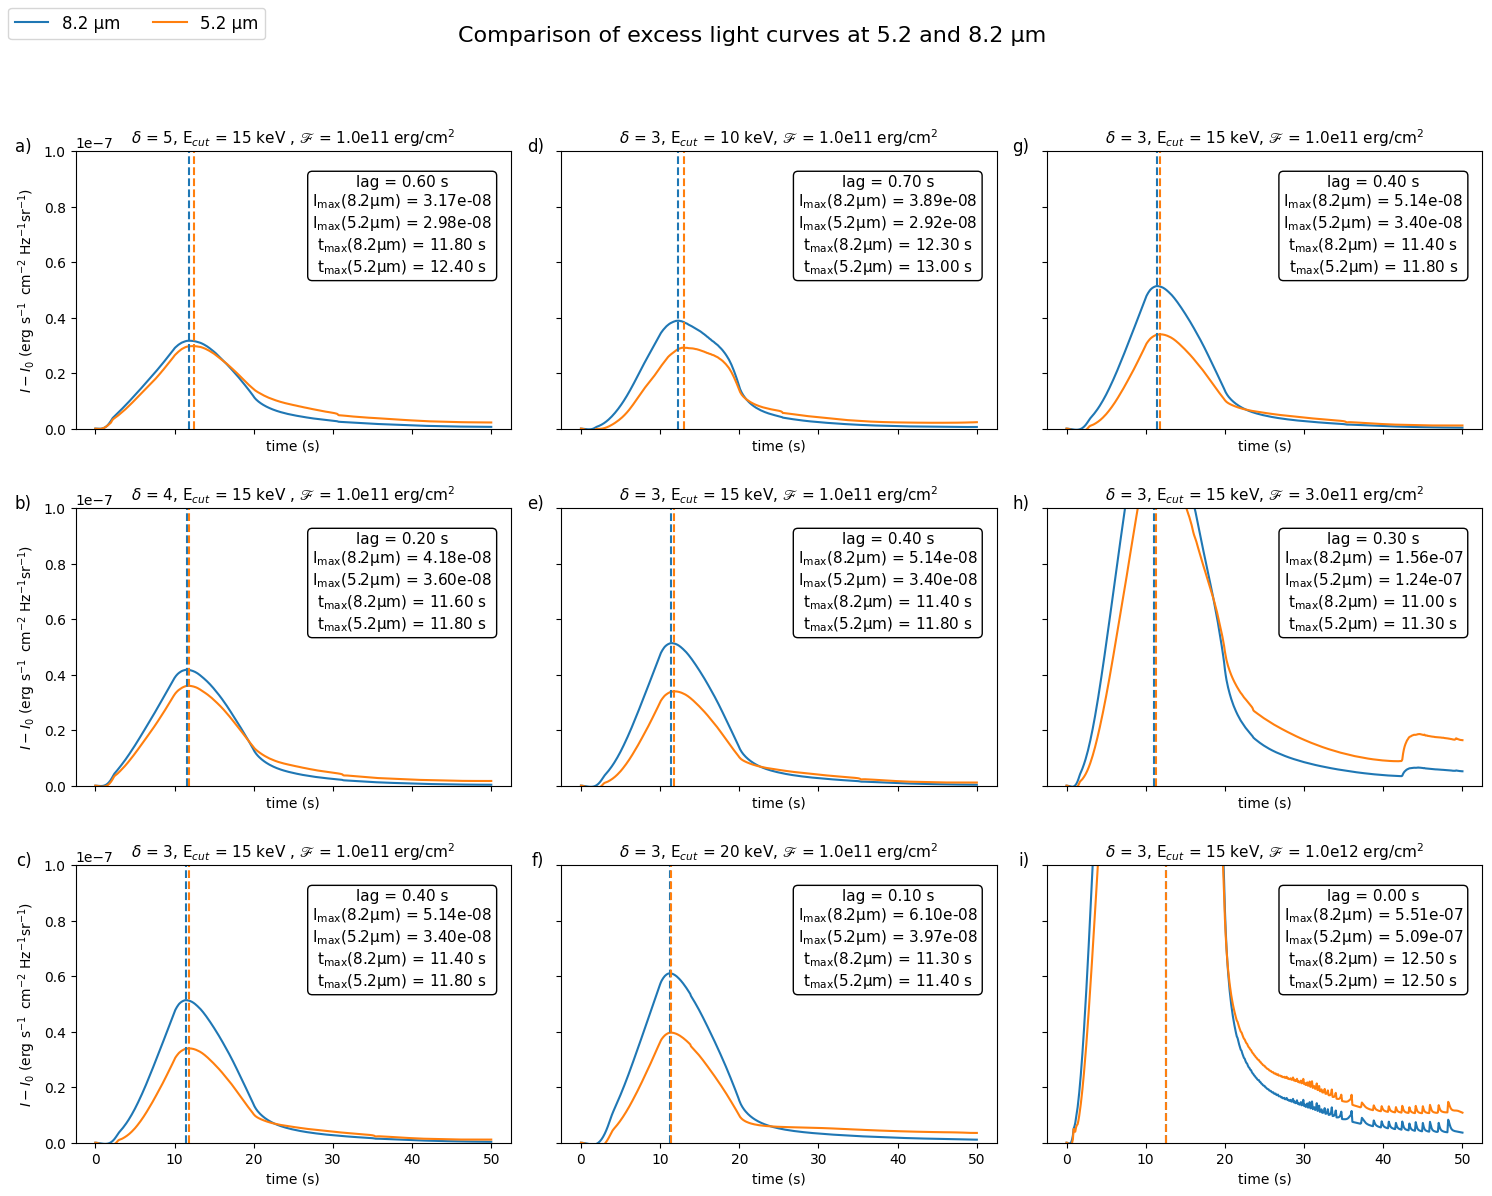

In [50]:
# Folder where the .pkl files are located
input_folder = f"{folder}/RADYN_Outputs_FChromaGrid"

def load_data(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

# figure 3x3
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)

# Leters to label panels
panel_labels = ['a)', 'b)','c)', 'd)','e)','f)','g)','h)','i)']
label_idx = 0

# ---------------------------------------------------
# Column 1: Spectral index (d3, d4, d5)
indices = [5, 4, 3]
j = 0
for i, d in enumerate(indices):
    filename = f"radyn_out.val3c_d{d}_1.0e11_t20s_15kev_fp_processed.pkl"
    data = load_data(os.path.join(input_folder, filename))
    times = data["times_1"]
    I5, I8 = data["I_5um"], data["I_8um"]

    ax = axes[i, j]
    ax.text(-0.1, 1.05, panel_labels[label_idx], transform=ax.transAxes,
            fontsize=12, va='top', ha='right')
    label_idx += 1

    ax.plot(times, (I8 - I8[0]), color='C0', label="8.2 µm")
    ax.plot(times, (I5 - I5[0]), color='C1', label="5.2 µm")

    max_t8 = times[np.argmax(I8)]
    max_t5 = times[np.argmax(I5)]
    max_I8 = np.max(I8 - I8[0])
    max_I5 = np.max(I5 - I5[0])

    ax.axvline(x=max_t8, color='C0', linestyle = "--")
    ax.axvline(x=max_t5, color='C1', linestyle = "--")

    ax.set_xlabel("time (s)")
    ax.set_ylabel(r"$I - I_{0}$ ($\operatorname{erg~s}^{-1} \mathrm{~cm}^{-2} \mathrm{~Hz}^{-1} \mathrm{sr}^{-1}$)")
    ax.set_ylim(0, 13e-08)

    delay_max = max_t5 - max_t8
    ax.text(0.75, 0.55,
            f"lag = {delay_max:.2f} s\n"
            f"I$_{{\\text{{max}}}}$(8.2µm) = {max_I8:.2e}\n"
            f"I$_{{\\text{{max}}}}$(5.2µm) = {max_I5:.2e}\n"
            f"t$_{{\\text{{max}}}}$(8.2µm) = {max_t8:.2f} s\n"
            f"t$_{{\\text{{max}}}}$(5.2µm) = {max_t5:.2f} s",
            transform=ax.transAxes, ha="center", va="bottom", fontsize=11,
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"))

    ax.set_title(r"$\delta$ = " + f"{d}" + r", E$_{cut}$ = 15 keV , $\mathscr{F}$ = 1.0e11 erg/cm$^2$", fontsize=11)


# ---------------------------------------------------
# Column 2: Energy cuto-ff (10, 15, 20)
cutoffs = [10, 15, 20]
j = 1
for i, ec in enumerate(cutoffs):
    filename = f"radyn_out.val3c_d3_1.0e11_t20s_{ec}kev_fp_processed.pkl"
    data = load_data(os.path.join(input_folder, filename))
    times = data["times_1"]
    I5, I8 = data["I_5um"], data["I_8um"]

    ax = axes[i, j]
    ax.text(-0.04, 1.05, panel_labels[label_idx], transform=ax.transAxes,
            fontsize=12, va='top', ha='right')
    label_idx += 1

    ax.plot(times, (I8 - I8[0]), color='C0', label="8.2 µm")
    ax.plot(times, (I5 - I5[0]), color='C1', label="5.2 µm")

    max_t8 = times[np.argmax(I8)]
    max_t5 = times[np.argmax(I5)]
    max_I8 = np.max(I8 - I8[0])
    max_I5 = np.max(I5 - I5[0])

    ax.axvline(x=max_t8, color='C0', linestyle = "--")
    ax.axvline(x=max_t5, color='C1', linestyle = "--")

    ax.set_xlabel("time (s)")
    ax.set_ylim(0, 13e-08)

    delay_max = max_t5 - max_t8
    ax.text(0.75, 0.55,
            f"lag = {delay_max:.2f} s\n"
            f"I$_{{\\text{{max}}}}$(8.2µm) = {max_I8:.2e}\n"
            f"I$_{{\\text{{max}}}}$(5.2µm) = {max_I5:.2e}\n"
            f"t$_{{\\text{{max}}}}$(8.2µm) = {max_t8:.2f} s\n"
            f"t$_{{\\text{{max}}}}$(5.2µm) = {max_t5:.2f} s",
            transform=ax.transAxes, ha="center", va="bottom", fontsize=11,
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"))

    ax.set_title(r"$\delta$ = 3, E$_{cut}$ = " + f"{ec}" + r" keV, $\mathscr{F}$ = 1.0e11 erg/cm$^2$",fontsize=11)


# ---------------------------------------------------
# Column 3: Values of Fluency (1.0e11, 3.0e11, 1.0e12)
energies = ["1.0e11", "3.0e11", "1.0e12"]
j = 2
for i, en in enumerate(energies):
    filename = f"radyn_out.val3c_d3_{en}_t20s_15kev_fp_processed.pkl"
    data = load_data(os.path.join(input_folder, filename))
    times = data["times_1"]
    I5, I8 = data["I_5um"], data["I_8um"]

    ax = axes[i, j]
    ax.text(-0.04, 1.05, panel_labels[label_idx], transform=ax.transAxes,
            fontsize=12, va='top', ha='right')
    label_idx += 1

    ax.plot(times, (I8 - I8[0]), color='C0', label="8.2 µm")
    ax.plot(times, (I5 - I5[0]), color='C1', label="5.2 µm")

    max_t8 = times[np.argmax(I8)]
    max_t5 = times[np.argmax(I5)]
    max_I8 = np.max(I8 - I8[0])
    max_I5 = np.max(I5 - I5[0])

    ax.axvline(x=max_t8, color='C0', linestyle = "--")
    ax.axvline(x=max_t5, color='C1', linestyle = "--")

    ax.set_xlabel("time (s)")
    ax.set_ylim(0, 10e-08)

    delay_max = max_t5 - max_t8
    ax.text(0.75, 0.55,
            f"lag = {delay_max:.2f} s\n"
            f"I$_{{\\text{{max}}}}$(8.2µm) = {max_I8:.2e}\n"
            f"I$_{{\\text{{max}}}}$(5.2µm) = {max_I5:.2e}\n"
            f"t$_{{\\text{{max}}}}$(8.2µm) = {max_t8:.2f} s\n"
            f"t$_{{\\text{{max}}}}$(5.2µm) = {max_t5:.2f} s",
            transform=ax.transAxes, ha="center", va="bottom", fontsize=11,
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"))

    ax.set_title(r"$\delta$ = 3, E$_{cut}$ = 15 keV, $\mathscr{F}$ = " + f"{en}" + r" erg/cm$^2$", fontsize=11)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", ncol=2, fontsize=12)
plt.suptitle("Comparison of excess light curves at 5.2 and 8.2 µm", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Sampled version:

Text(0.5, 1.0, '$\\delta$ = 3, E$_{cut}$ = 15 keV, $\\mathscr{F}$ = 1.0e11 erg/cm$^2$')

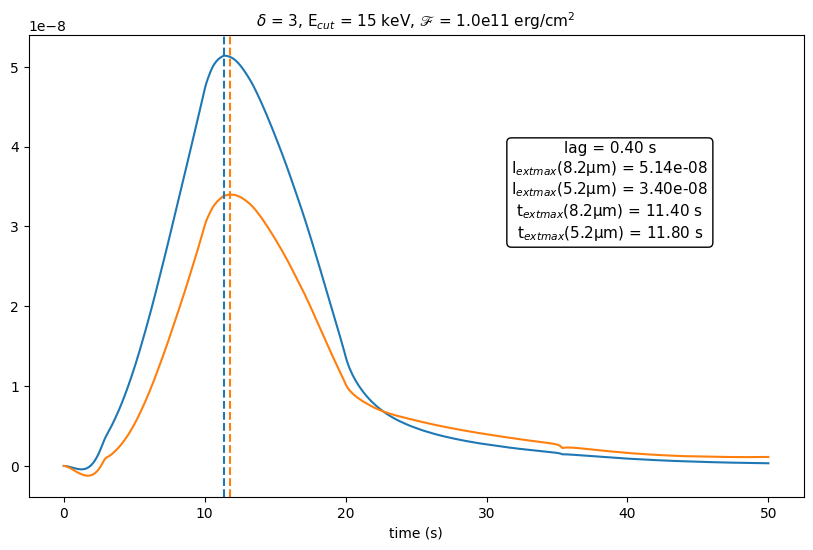

In [51]:
filename = f"radyn_out.val3c_d3_1.0e11_t20s_15kev_fp_processed.pkl"
data = load_data(os.path.join(input_folder, filename))
times = data["times_1"]
I_5um, I_8um = data["I_5um"], data["I_8um"]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(times, (I_8um - I_8um[0]), color='C0', label="8.2 µm")
ax.plot(times, (I_5um - I_5um[0]), color='C1', label="5.2 µm")

max_t8 = times[np.argmax(I_8um)]
max_t5 = times[np.argmax(I_5um)]
max_I8 = np.max(I_8um - I_8um[0])
max_I5 = np.max(I_5um - I_5um[0])

ax.axvline(x=max_t8, color='C0', linestyle = "--")
ax.axvline(x=max_t5, color='C1', linestyle = "--")

ax.set_xlabel("time (s)")

delay_max = max_t5 - max_t8
ax.text(0.75, 0.55,
        f"lag = {delay_max:.2f} s\n"
        f"I$_{{\text{{max}}}}$(8.2µm) = {max_I8:.2e}\n"
        f"I$_{{\text{{max}}}}$(5.2µm) = {max_I5:.2e}\n"
        f"t$_{{\text{{max}}}}$(8.2µm) = {max_t8:.2f} s\n"
        f"t$_{{\text{{max}}}}$(5.2µm) = {max_t5:.2f} s",
        transform=ax.transAxes, ha="center", va="bottom", fontsize=11,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"))

ax.set_title(r"$\delta$ = 3, E$_{cut}$ = 15 keV, $\mathscr{F}$ = 1.0e11 erg/cm$^2$", fontsize=11)

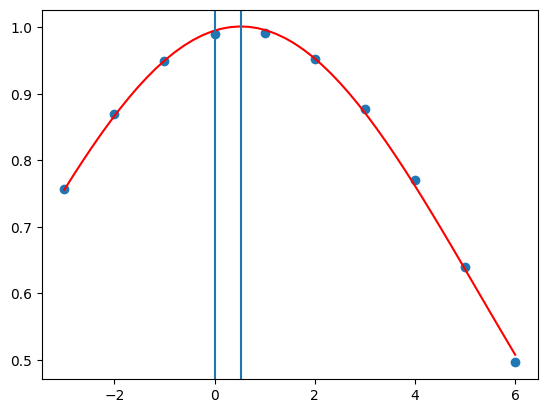

Estimated time lag (max value of the fitting function): 0.52s
Standard deviation error of the fitting 0.026s


In [55]:
# Submuestreo: tomar una muestra cada 10 elementos
I_8um_sampled = I_8um[::10]
I_5um_sampled = I_5um[::10]

T_ccf=TlocalCCF(I_8um_sampled,I_5um_sampled)
K=len(I_8um_sampled)
lags = np.arange(-K+3, K-2, 1)*1

x1=lags[45:55]
y1=T_ccf[45:55]

n = len(x1)                          #the number of data
mean = sum(x1*y1)/n
sigma = sum(y1*(x1-mean)**2)/n

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x1,y1,p0=[1,mean,sigma])

plt.plot(lags[45:55], T_ccf[45:55],"o")
x_ls=np.linspace(-3, 6, num=50)
plt.plot(x_ls,gaus(x_ls,*popt),'r')
plt.axvline(x = popt[1])
plt.axvline(x = 0)

plt.show()

print(f"Estimated time lag (max value of the fitting function): {round(popt[1],2)}s")
perr = np.sqrt(np.diag(pcov))
print(f"Standard deviation error of the fitting {round(perr[1],3)}s")

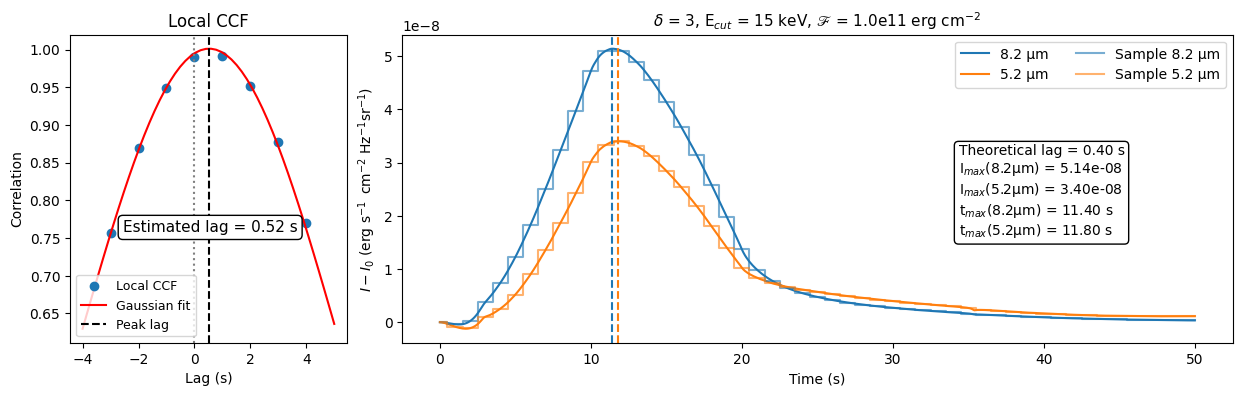

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit

# ============================================================
# Load RADYN processed data
# ============================================================

filename = "radyn_out.val3c_d3_1.0e11_t20s_15kev_fp_processed.pkl"
data = load_data(os.path.join(input_folder, filename))

times = data["times_1"]
I5 = data["I_5um"]
I8 = data["I_8um"]

# ============================================================
# Sample signals (effective cadence reduction)
# ============================================================

times_s = times[::10]
I5_s = I5[::10]
I8_s = I8[::10]

# ============================================================
# Local cross-correlation function (CCF)
# ============================================================

T_ccf = TlocalCCF(I8_s, I5_s)
K = len(I8_s)
lags = np.arange(-K + 3, K - 2, 1) * 1  # lag in seconds

# Select local region around the CCF peak
x1 = lags[45:55]
y1 = T_ccf[45:55]

# Initial estimates for Gaussian fit
n = len(x1)
mean = np.sum(x1 * y1) / n
sigma = np.sum(y1 * (x1 - mean)**2) / n

def gaus(x, a, x0, sigma):
    """Gaussian model for fitting the CCF peak."""
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

popt, pcov = curve_fit(gaus, x1, y1, p0=[1, mean, sigma])

# Parameter uncertainties from covariance matrix
perr = np.sqrt(np.diag(pcov))

# ============================================================
# Peak values of the intensity curves
# ============================================================

max_t8 = times[np.argmax(I8)]
max_t5 = times[np.argmax(I5)]
max_I8 = np.max(I8 - I8[0])
max_I5 = np.max(I5 - I5[0])
delay_max = max_t5 - max_t8

# ============================================================
# Figure layout (CCF on the left, intensities on the right)
# ============================================================

fig = plt.figure(figsize=(15, 4))
gs = GridSpec(1, 2, width_ratios=[1, 3], wspace=0.1)

ax_ccf = fig.add_subplot(gs[0])
ax_sig = fig.add_subplot(gs[1])

# ============================================================
# LEFT PANEL: Local CCF
# ============================================================

ax_ccf.plot(lags[45:53], T_ccf[45:53], "o", label="Local CCF")

x_ls = np.linspace(-4, 5, num=50)
ax_ccf.plot(x_ls, gaus(x_ls, *popt), 'r', label="Gaussian fit")

# Vertical reference lines
ax_ccf.axvline(popt[1], color='k', linestyle="--", label="Peak lag")
ax_ccf.axvline(0, color='gray', linestyle=":")

ax_ccf.set_xlabel("Lag (s)")
ax_ccf.set_ylabel("Correlation")
ax_ccf.set_title("Local CCF")
ax_ccf.legend(fontsize=9, loc="lower left")

x_middle = 0.5 * popt[1]+0.3

ax_ccf.text(
    x_middle, 0.35,
    f"Estimated lag = {popt[1]:.2f} s",
    ha="center", va="bottom",
    transform=ax_ccf.get_xaxis_transform(),
    fontsize=11,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
)


# ============================================================
# RIGHT PANEL: Intensity time series
# ============================================================

ax_sig.plot(times, I8 - I8[0], color='C0', label="8.2 µm")
ax_sig.plot(times, I5 - I5[0], color='C1', label="5.2 µm")

# Sampled points shown as centered step functions
ax_sig.step(
    times_s, I8_s - I8[0],
    where="mid",
    color='C0', alpha=0.6,
    label="Sample 8.2 µm")

ax_sig.step(
    times_s, I5_s - I5[0],
    where="mid",
    color='C1', alpha=0.6,
    label="Sample 5.2 µm")

# Sampled points
#ax_sig.step(
#    times_s, I8_s - I8[0], color='C0', ms=4, alpha=0.6,
#    label="Sample 8.2 µm")

#ax_sig.step(
#    times_s, I5_s - I5[0], color='C1', ms=4, alpha=0.6,
#    label="Sample 5.2 µm")

# Vertical lines at intensity maxima
ax_sig.axvline(max_t8, color='C0', linestyle="--")
ax_sig.axvline(max_t5, color='C1', linestyle="--")

ax_sig.set_xlabel("Time (s)")
ax_sig.set_ylabel(r"$I - I_{0}$ ($\operatorname{erg~s}^{-1} \mathrm{~cm}^{-2} \mathrm{~Hz}^{-1} \mathrm{sr}^{-1}$)")
ax_sig.legend(ncol=2)

ax_sig.set_title(
    r"$\delta$ = 3, E$_{cut}$ = 15 keV, "
    r"$\mathscr{F}$ = 1.0e11 erg cm$^{-2}$",
    fontsize=11
)

# Text box with timing and intensity information
ax_sig.text(
    0.67, 0.35,
    f"Theoretical lag = {delay_max:.2f} s\n"
    f"I$_{{max}}$(8.2µm) = {max_I8:.2e}\n"
    f"I$_{{max}}$(5.2µm) = {max_I5:.2e}\n"
    f"t$_{{max}}$(8.2µm) = {max_t8:.2f} s\n"
    f"t$_{{max}}$(5.2µm) = {max_t5:.2f} s",
    transform=ax_sig.transAxes,
    fontsize=10,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
)

plt.show()
